# Setup

---



Install python packages.

In [0]:
!pip install scanpy
!pip install python-igraph
!pip install louvain
!pip install seaborn
!pip install scipy
!pip install sklearn
!pip install diffxpy
!pip install bbknn
!pip install loompy

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import csv
import scanpy as sc
import seaborn as sb
import scipy as sp
import matplotlib.pyplot as plt
import diffxpy.api as de
import bbknn as bk
import base64
import json
import os
import zlib
#from optparse import OptionParser
import loompy as lp

In [0]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = '/content/drive/My Drive/IntegratedProject/Data/write/results_fat.h5ad'  # the file that will store the analysis results

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.4 scipy==1.3.3 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.2 python-igraph==0.7.1 louvain==0.6.1


In [0]:
sc.settings.set_figure_params(dpi=80)

# Data selection

---



In [0]:
meta = pd.read_csv("/content/drive/My Drive/IntegratedProject/Data/Metadata/TM_facs_metadata.csv") #need to switch to metadata for entire set of data
adata = sc.read_csv(
    '/content/drive/My Drive/IntegratedProject/Data/TM_facs_mat_fat.csv') #file needs to be switched to one containing all the data

In [0]:
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

Adding new columns to adata.obs to keep track of plate, id of the mouse, sex of the mouse, tissue, subtiusse and the cell annotation from the original paper.

Then each of these columns is filled with the respective data from the metadata for each cell.

In [0]:
adata.obs = adata.obs.assign(plate='')
adata.obs = adata.obs.assign(mouse_id='')
adata.obs = adata.obs.assign(mouse_sex='')
adata.obs = adata.obs.assign(tissue='')
adata.obs = adata.obs.assign(subtissue='')
adata.obs = adata.obs.assign(ref_annotation='')

for i in range(len(meta)):
  cellid = meta.iloc[i,0]
  if cellid in adata.obs_names:
    adata.obs.loc[cellid, 'plate'] = meta.iloc[i,1]
    adata.obs.loc[cellid, 'mouse_id'] = meta.iloc[i,2]
    adata.obs.loc[cellid, 'mouse_sex'] = meta.iloc[i,6]
    adata.obs.loc[cellid, 'tissue'] = meta.iloc[i,3]
    adata.obs.loc[cellid, 'subtissue'] = meta.iloc[i,4]
    adata.obs.loc[cellid, 'ref_annotation'] = meta.iloc[i,7]

In [0]:
adata

AnnData object with n_obs × n_vars = 5862 × 23433 
    obs: 'plate', 'mouse_id', 'mouse_sex', 'tissue', 'subtissue', 'ref_annotation'

# Pre-processing

First we remove the spike in ERCC genes.

In [0]:
adata = adata[:,adata.var_names.str.startswith('ERCC')!=True]
adata

View of AnnData object with n_obs × n_vars = 5862 × 23341 
    obs: 'plate', 'mouse_id', 'mouse_sex', 'tissue', 'subtissue', 'ref_annotation'

Each cell and gene are individually shown to see how many genes are expressed in each cell as well as how many cells each gene is expressed in.

In [0]:
sc.pp.calculate_qc_metrics(adata)

(                         n_genes_by_counts  ...  pct_counts_in_top_500_genes
 A1.B000127.3_38_F.1.1                 1105  ...                    97.254979
 A1.B002314.3_56_F.1.1                 3097  ...                    71.227407
 A1.B002707.3_39_F.1.1                  361  ...                   100.000000
 A1.B002954.3_56_F.1.1                  703  ...                    98.719485
 A1.B002955.3_56_F.1.1                  389  ...                   100.000000
 ...                                    ...  ...                          ...
 P9.MAA000556.3_9_M.1.1                1424  ...                    92.876862
 P9.MAA000877.3_11_M.1.1               2376  ...                    82.240139
 P9.MAA000913.3_9_M.1.1                2009  ...                    76.965959
 P9.MAA000914.3_9_M.1.1                1330  ...                    93.646008
 P9.MAA000934.3_9_M.1.1                1508  ...                    87.289529
 
 [5862 rows x 8 columns],
                    n_cells_by_count

Basic filtering on our data so that genes that are detected in less than 3 cells are removed as well as cells that have less than 500 genes expressed and cells that have less than 50,000 counts.

In [0]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_cells(adata, min_counts=50000)
sc.pp.filter_genes(adata, min_cells=3)
adata

filtered out 727 cells that haveless than 500 genes expressed


Trying to set attribute `.obs` of view, making a copy.


filtered out 168 cells that haveless than 50000 counts
filtered out 4282 genes that are detectedin less than 3 cells


AnnData object with n_obs × n_vars = 4967 × 19059 
    obs: 'plate', 'mouse_id', 'mouse_sex', 'tissue', 'subtissue', 'ref_annotation', 'n_genes', 'n_counts'
    var: 'n_cells'

Computes for each gene the fraction of counts assigned to that gene within a cell and shows a boxplot with the top 20 genes with the highest mean fraction across all cells.

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


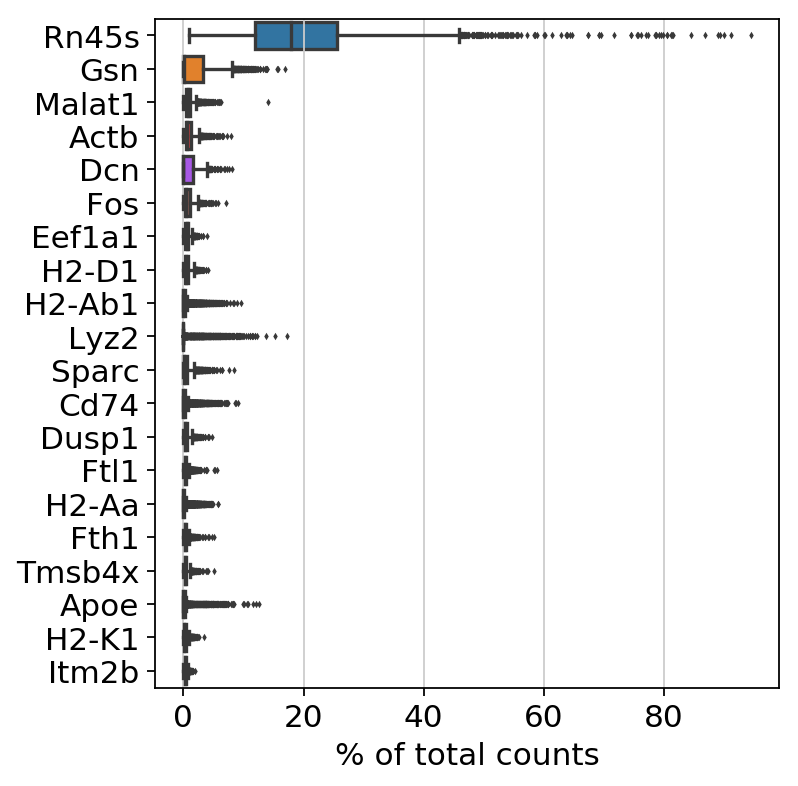

In [0]:
sc.pl.highest_expr_genes(adata, n_top=20)

Collect a list of the mitochondrial genes in our data set and create a new observation column in the adata.obs percent_mito which is the percentage of mitochondrial gene counts vs all total gene counts.

Having information about mitochonrdrial genes is important because high proportions are indicative of poor-quality cells since this could indicate a cell with tears in the cell membrane and since mitochondria are larger than individual transcript molecules they are less likely to escape through the tears.

The n_counts observation is also updated to account for the filtering done previously.

In [0]:
mito_genes = adata.var_names.str.startswith('mt-','tssr')

adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)

adata.obs['n_counts'] = adata.X.sum(axis=1)

Create a violin plot for the number of genes and counts for each cell to provide more information about our cells for future filtering.

... storing 'plate' as categorical
... storing 'mouse_id' as categorical
... storing 'mouse_sex' as categorical
... storing 'tissue' as categorical
... storing 'subtissue' as categorical
... storing 'ref_annotation' as categorical


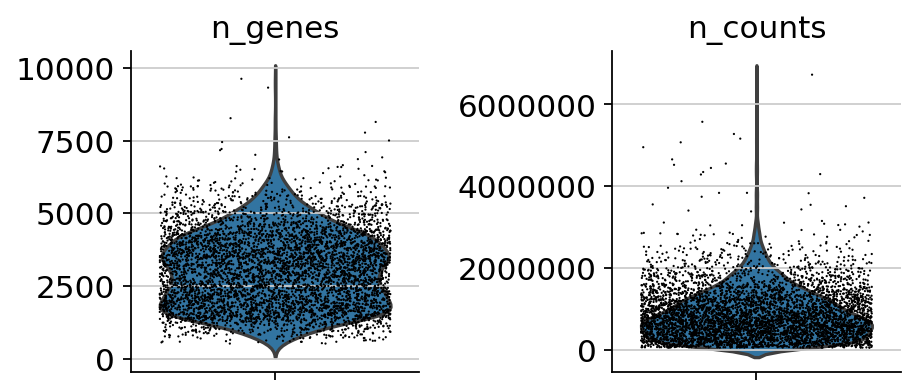

In [0]:
sc.pl.violin(adata, ['n_genes', 'n_counts'],
             jitter=0.4, multi_panel=True)


Create two scatter plots, the first comparing the number of counts and percentage of mitochonridal genes and the second comparing number of counts and number of genes for our dataset.

The first scatter plot is commented out because we do not actually have any mitochondrial genes in our data.



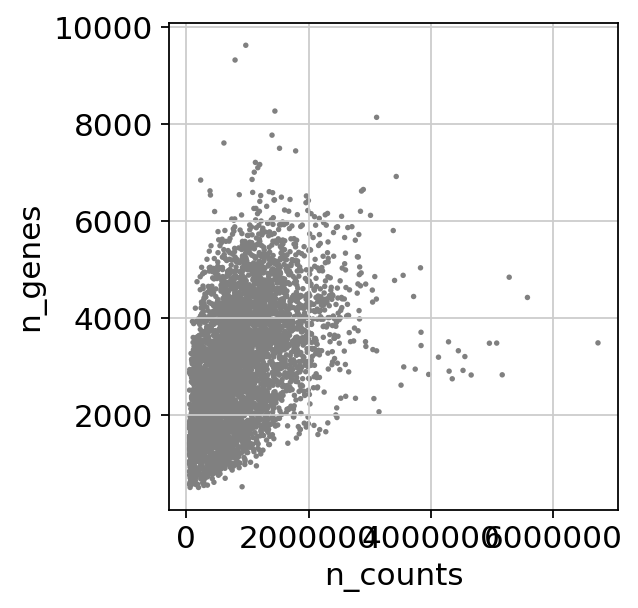

In [0]:
#sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

Check our data to see how the number of counts and number of genes are distributed across our cells.

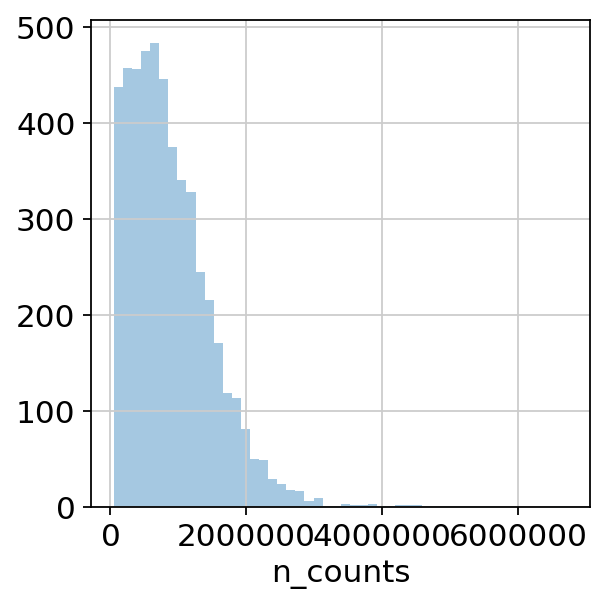

In [0]:
sb.distplot(adata.obs['n_counts'], kde=False)

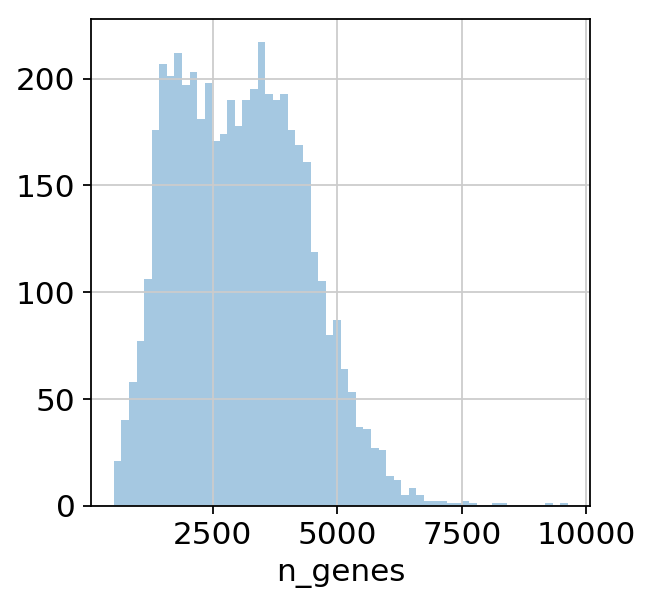

In [0]:
sb.distplot(adata.obs['n_genes'], kde=False, bins=60)

Based on the previous plots we filter our data again to remove cells with too low or too high number of genes and cells with too low and too high number of counts. If there were mitochondrial genes present then cells with too high a percentage of those genes would be removed also.

These cells are filtered out to remove outliers from our data.

In [0]:
adata = adata[adata.obs['n_genes'] > 500, :]
adata = adata[adata.obs['n_genes'] < 7000, :]
adata = adata[adata.obs['n_counts'] > 50000, :]
adata = adata[adata.obs['n_counts'] < 3200000, :]
#adata = adata[adata.obs['percent_mito'] < 0.05, :]

In [0]:
adata

View of AnnData object with n_obs × n_vars = 4929 × 19059 
    obs: 'plate', 'mouse_id', 'mouse_sex', 'tissue', 'subtissue', 'ref_annotation', 'n_genes', 'n_counts', 'percent_mito'
    var: 'n_cells'

Make new object adata.raw which is adata in its current state the raw (un-normalized, uncorrected and unscaled) form of our data.

In [0]:
adata.raw = adata

Total-count normalize the data matrix to 10,000 reads per cell, so that counts become comparable among cells.

In [0]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


Logarithmize the data.

In [0]:
sc.pp.log1p(adata)

Filter adata to only include genes that are highly variable.

Regress out effects of total counts per cell.

In [0]:
sc.pp.regress_out(adata, ['n_counts'])

regressing out ['n_counts']
    finished (0:02:03)


Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [0]:
sc.pp.scale(adata, max_value=10)

In [0]:
adata.write(results_file)

# Differential Expression

Creating function to make pairwise volcano plots between cell sub-populations.

In [0]:
def pairwiseDE(test_by,test_groups,subset_by=None,subset=None):
  if subset_by:
    adata_sub = adata[adata.obs[subset_by].str.contains(subset)]
  else:
    adata_sub = adata

  i=0
  while i < len(test_groups)-1:
    for j in range(i+1,len(test_groups)):
      pair = [test_groups[i], test_groups[j]]
      print ("Differential expression: %s vs %s" %(pair[0],pair[1]))
      regex = '|'.join(pair)
      adata_test = adata_sub[adata_sub.obs[test_by].str.contains(regex)]
      grouping = adata_test.obs[test_by].tolist()
      test = de.test.two_sample(adata_test.raw.X, grouping, gene_names=adata_test.var_names.to_list())
      test.plot_volcano()
      table = test.summary().sort_values('pval', axis = 0, ascending=True)
      print(table.iloc[:20,:])
    i+=1

Differential expression of fat B cells between subtissues: MAT, SCAT, BAT and GAT.

Differential expression: MAT vs BAT


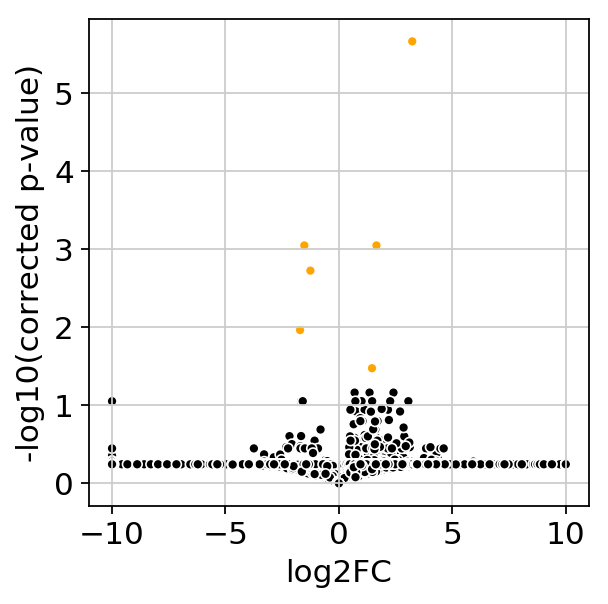

          gene          pval      qval  ...         mean  zero_mean  zero_variance
9823     Lars2  1.469734e-10  0.000002  ...   426.863190      False          False
9336      Jund  1.410087e-07  0.000891  ...   424.032567      False          False
9857      Lcp1  1.822832e-07  0.000891  ...   306.954396      False          False
9573      Klf2  5.110392e-07  0.001874  ...   200.811075      False          False
6845       Fos  3.689752e-06  0.010826  ...  1014.003278      False          False
10329   Map3k1  1.366085e-05  0.033403  ...   122.931594      False          False
14623     Rps5  3.291766e-05  0.068616  ...   823.006503      False          False
3874      Cd38  3.777570e-05  0.068616  ...    71.644949      False          False
5849      Eef2  4.209258e-05  0.068616  ...   573.162857      False          False
15281    Sipa1  6.394539e-05  0.088439  ...   109.941365      False          False
14636     Rps8  7.102032e-05  0.088439  ...   262.775251      False          False
1807

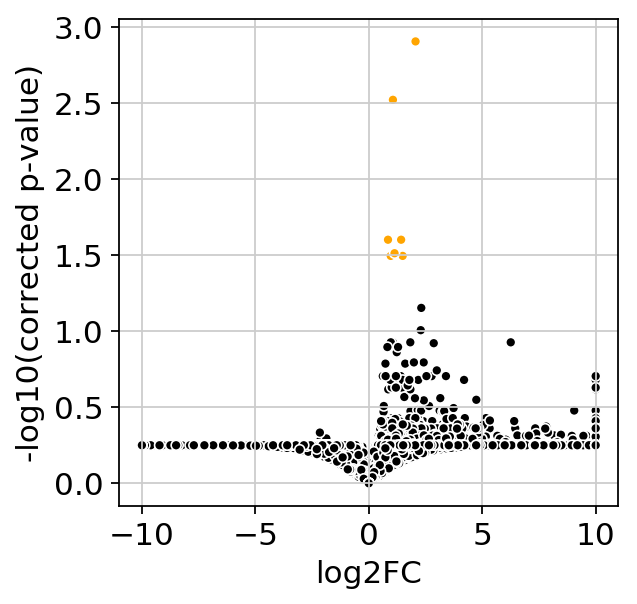

            gene          pval      qval  ...         mean  zero_mean  zero_variance
9823       Lars2  9.263807e-08  0.001248  ...   751.435575      False          False
1791        Actb  4.483858e-07  0.003019  ...  8398.675119      False          False
17868       Ucp2  7.318335e-06  0.025079  ...   419.975451      False          False
14530     Rpl13a  7.448585e-06  0.025079  ...   473.349676      False          False
9947       Limd2  1.142285e-05  0.030769  ...   420.552146      False          False
9857        Lcp1  1.549988e-05  0.032034  ...   433.392642      False          False
3887        Cd52  1.664964e-05  0.032034  ...   502.030662      False          False
13672      Psmb3  4.179254e-05  0.070358  ...   135.969327      False          False
11395       Myh9  6.587584e-05  0.098580  ...    29.380369      False          False
7955      Gnb2l1  9.338636e-05  0.118441  ...   791.490809      False          False
5943       Eif3f  1.025669e-04  0.118441  ...   292.171783      F

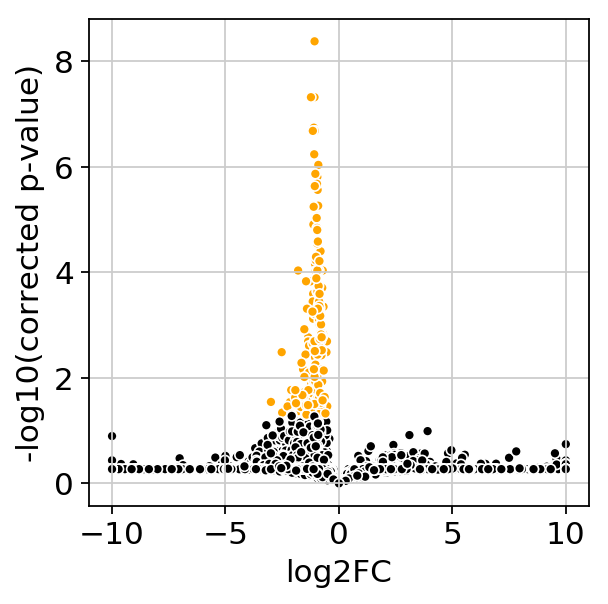

          gene          pval  ...  zero_mean  zero_variance
14614    Rps27  2.943869e-13  ...      False          False
14619     Rps3  7.958597e-12  ...      False          False
17773    Uba52  1.176992e-11  ...      False          False
7606    Gm1821  1.349690e-11  ...      False          False
14530   Rpl13a  6.374032e-11  ...      False          False
14535   Rpl18a  1.029651e-10  ...      False          False
14604    Rps19  1.058394e-10  ...      False          False
14623     Rps5  1.172972e-10  ...      False          False
14603    Rps18  3.662566e-10  ...      False          False
10293   Malat1  4.143638e-10  ...      False          False
14529    Rpl13  7.118628e-10  ...      False          False
14557    Rpl36  1.146466e-09  ...      False          False
6928      Fth1  1.421111e-09  ...      False          False
14601    Rps16  2.074081e-09  ...      False          False
14617    Rps28  2.447395e-09  ...      False          False
14567    Rpl41  2.690404e-09  ...      F

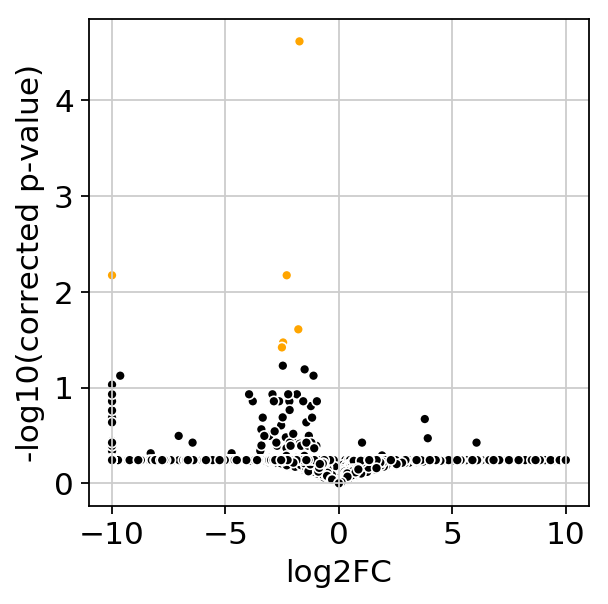

            gene          pval      qval  ...        mean  zero_mean  zero_variance
9336        Jund  1.731455e-09  0.000024  ...  480.256191      False          False
2354       Aplp1  1.074588e-06  0.006740  ...    0.152893      False          False
9492       Kdm6b  1.434255e-06  0.006740  ...  200.917357      False          False
8091      Gpr171  7.004823e-06  0.024687  ...  768.557837      False          False
8582   Hist1h2ao  1.201506e-05  0.033875  ...    0.842975      False          False
18447      Ypel5  1.623267e-05  0.038139  ...   66.838843      False          False
13141       Plp1  2.938163e-05  0.059170  ...    0.661157      False          False
11885     Notch2  3.668750e-05  0.064648  ...  172.111576      False          False
4684       Creb3  5.080186e-05  0.075265  ...   64.900828      False          False
9947       Limd2  5.339063e-05  0.075265  ...  443.450412      False          False
1789       Acta1  7.602408e-05  0.093329  ...    0.115702      False        

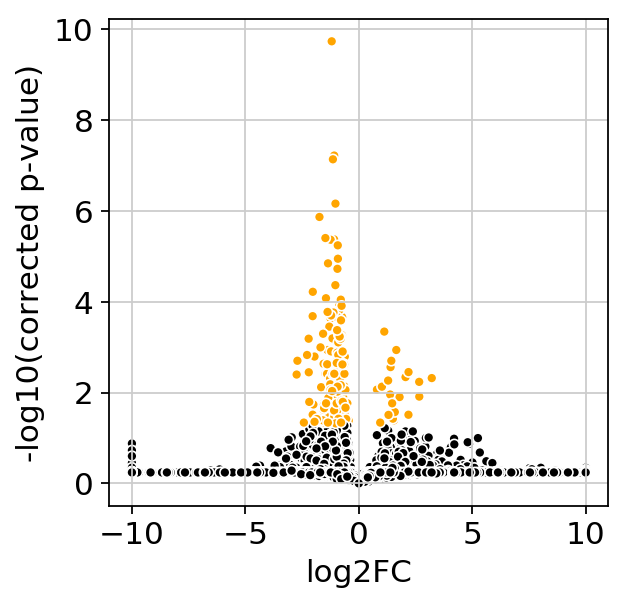

          gene          pval  ...  zero_mean  zero_variance
10293   Malat1  1.250328e-14  ...      False          False
14614    Rps27  8.197991e-12  ...      False          False
17783      Ubb  1.487528e-11  ...      False          False
6928      Fth1  1.876512e-10  ...      False          False
9336      Jund  4.612314e-10  ...      False          False
14618    Rps29  1.611286e-09  ...      False          False
6579       Fau  2.011211e-09  ...      False          False
8383     H3f3b  2.344487e-09  ...      False          False
14604    Rps19  3.497085e-09  ...      False          False
7606    Gm1821  7.669442e-09  ...      False          False
14617    Rps28  1.065895e-08  ...      False          False
14635     Rps7  1.533655e-08  ...      False          False
14527    Rpl11  3.807493e-08  ...      False          False
3896      Cd69  5.742083e-08  ...      False          False
8911      Ier2  8.525161e-08  ...      False          False
14596    Rps14  9.783295e-08  ...      F

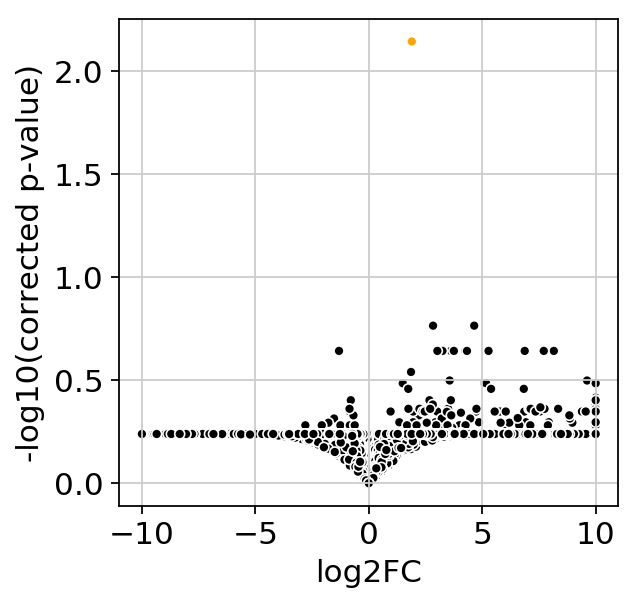

           gene          pval      qval  ...        mean  zero_mean  zero_variance
16014     Sp110  5.295393e-07  0.007200  ...  123.227493      False          False
9072      Il4ra  2.640044e-05  0.172082  ...   72.521329      False          False
10139   Lrrfip1  5.055849e-05  0.172082  ...   57.127961      False          False
15191    Sh2d2a  5.062340e-05  0.172082  ...   33.739337      False          False
1714      Acat1  1.062628e-04  0.228130  ...   48.834123      False          False
12473     Panx1  1.222719e-04  0.228130  ...   18.407583      False          False
17384     Traf7  1.452120e-04  0.228130  ...   33.687204      False          False
17553   Tsc22d3  1.792013e-04  0.228130  ...  737.957363      False          False
18898    Zfp869  1.843925e-04  0.228130  ...   28.734596      False          False
13689    Psmd12  1.939139e-04  0.228130  ...   30.066352      False          False
14364     Riok3  2.035933e-04  0.228130  ...   24.421800      False          False
6812

In [0]:
subset_by = 'ref_annotation'
subset = 'B cell'
test_by = 'subtissue'
test_groups = ['MAT', 'BAT', 'GAT', 'SCAT']
pairwiseDE(test_by, test_groups, subset_by, subset)

Differential expression of fat T cells between subtissues: MAT, SCAT, BAT and GAT.





Differential expression: MAT vs BAT


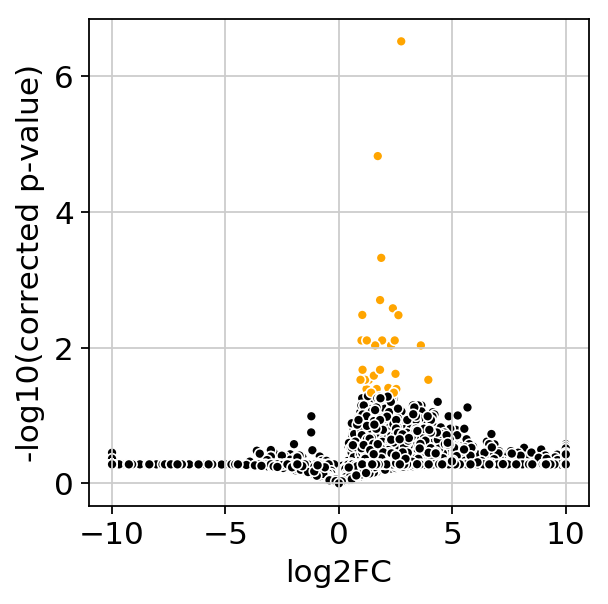

         gene          pval  ...  zero_mean  zero_variance
9823    Lars2  2.142706e-11  ...      False          False
5849     Eef2  2.104301e-09  ...      False          False
3931    Cdc37  9.980877e-08  ...      False          False
11634  Ndufb7  5.572359e-07  ...      False          False
11700  Neurl3  9.213720e-07  ...      False          False
7739   Gm5148  1.522159e-06  ...      False          False
3284     Bzw1  1.615303e-06  ...      False          False
16943  Tm9sf2  1.860746e-06  ...      False          False
18070     Vcp  5.269835e-06  ...      False          False
3504   Capza1  5.838767e-06  ...      False          False
1791     Actb  6.380409e-06  ...      False          False
15042  Serbp1  6.579934e-06  ...      False          False
8664    Hmha1  9.221939e-06  ...      False          False
14055  Rasal3  9.526501e-06  ...      False          False
17801  Ube2j1  9.734216e-06  ...      False          False
3934    Cdc42  2.431148e-05  ...      False          Fal

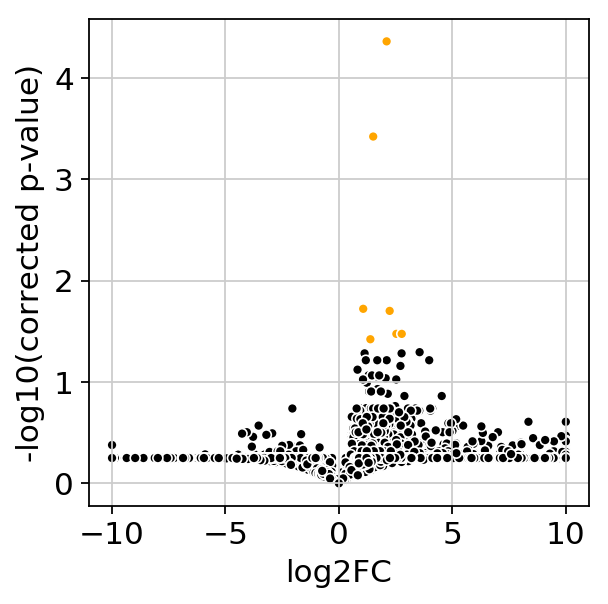

          gene          pval      qval  ...         mean  zero_mean  zero_variance
9823     Lars2  3.145447e-09  0.000044  ...  1042.914480      False          False
17953    Uqcrh  5.468593e-08  0.000378  ...    99.743422      False          False
7739    Gm5148  4.108187e-06  0.018955  ...    12.526316      False          False
16014    Sp110  5.744077e-06  0.019877  ...   151.032898      False          False
15741     Smc3  1.267050e-05  0.033501  ...    98.460522      False          False
9134      Ins2  1.452159e-05  0.033501  ...     1.513158      False          False
9877      Lef1  1.914407e-05  0.037856  ...   240.315787      False          False
8879      Iapp  2.934752e-05  0.050779  ...     0.348684      False          False
5553   Dnttip2  3.558340e-05  0.052187  ...    79.723684      False          False
6044      Eno1  3.770162e-05  0.052187  ...    80.322369      False          False
7762    Gm5506  5.450076e-05  0.060977  ...    10.493421      False          False
7222

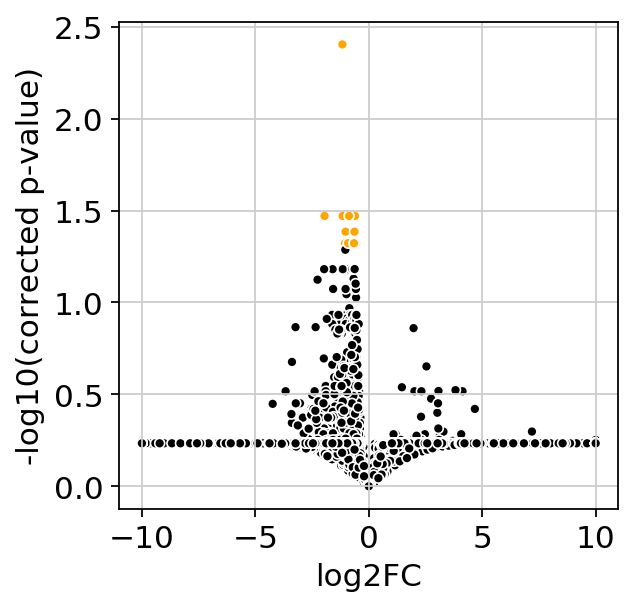

          gene          pval      qval  ...         mean  zero_mean  zero_variance
7221    Gimap6  2.701885e-07  0.003950  ...   677.475563      False          False
14126    Rbm38  4.671042e-06  0.033846  ...   119.422224      False          False
17784      Ubc  8.346711e-06  0.033846  ...   180.373329      False          False
14614    Rps27  1.150902e-05  0.033846  ...   178.053333      False          False
14607     Rps2  1.175451e-05  0.033846  ...   942.959988      False          False
14536    Rpl19  1.646887e-05  0.033846  ...   730.226661      False          False
7739    Gm5148  1.830778e-05  0.033846  ...    11.417778      False          False
9823     Lars2  1.851934e-05  0.033846  ...   969.266670      False          False
5485    Dnaja1  2.545285e-05  0.041233  ...   343.115561      False          False
2704    Atp1b3  2.850827e-05  0.041233  ...   837.977787      False          False
14570     Rpl7  3.102131e-05  0.041233  ...   829.404462      False          False
1457

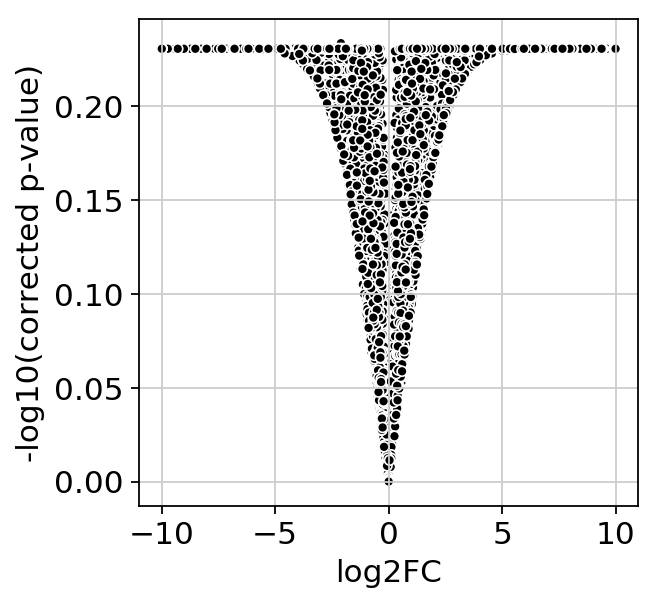

             gene      pval      qval  ...         mean  zero_mean  zero_variance
3804         Ccr7  0.000043  0.583980  ...  2610.674526      False          False
6054        Enpp2  0.000276  0.588004  ...     0.111111      False          False
3486        Capn1  0.000947  0.588004  ...     6.928572      False          False
9905       Lgals4  0.001116  0.588004  ...     0.079365      False          False
13206       Pnrc2  0.001199  0.588004  ...    61.619047      False          False
3905         Cd82  0.001219  0.588004  ...   207.793649      False          False
3115       Beta-s  0.001262  0.588004  ...     0.222222      False          False
17455      Trim35  0.001547  0.588004  ...    17.730159      False          False
16692     Tcp11l2  0.001677  0.588004  ...   142.523810      False          False
11931        Nptn  0.001850  0.588004  ...    46.341270      False          False
4184         Chga  0.001917  0.588004  ...     0.285714      False          False
2752      Atp6v1

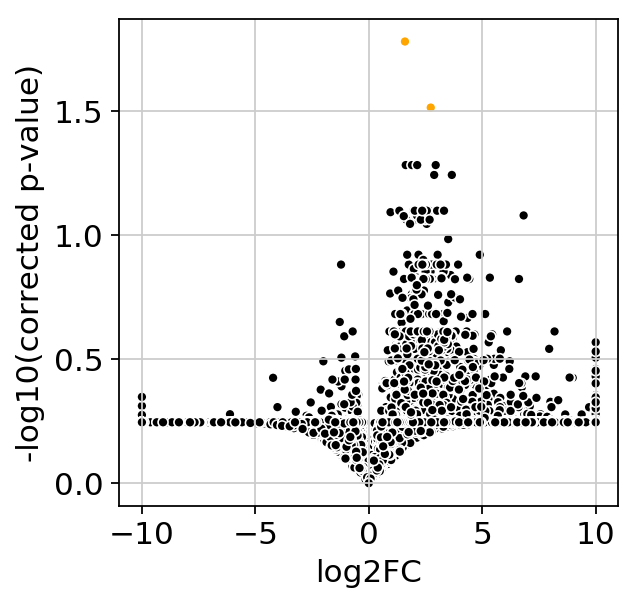

           gene      pval      qval  ...        mean  zero_mean  zero_variance
9823      Lars2  0.000001  0.016602  ...  457.040199      False          False
4671       Cr1l  0.000004  0.030645  ...   64.256280      False          False
11254      Mta2  0.000016  0.052248  ...   56.683416      False          False
12408    P2ry10  0.000018  0.052248  ...   98.211052      False          False
16943    Tm9sf2  0.000021  0.052248  ...   72.859297      False          False
3504     Capza1  0.000022  0.052248  ...   95.623113      False          False
5884     Eftud2  0.000030  0.057254  ...   45.457287      False          False
4823     Ctnnb1  0.000032  0.057254  ...   48.979899      False          False
16685     Tcof1  0.000050  0.079797  ...   35.351759      False          False
10355    Mapk14  0.000060  0.079797  ...   28.778895      False          False
7095    Gatad2a  0.000068  0.079797  ...   29.070352      False          False
11308      Mtpn  0.000075  0.079797  ...   58.552763

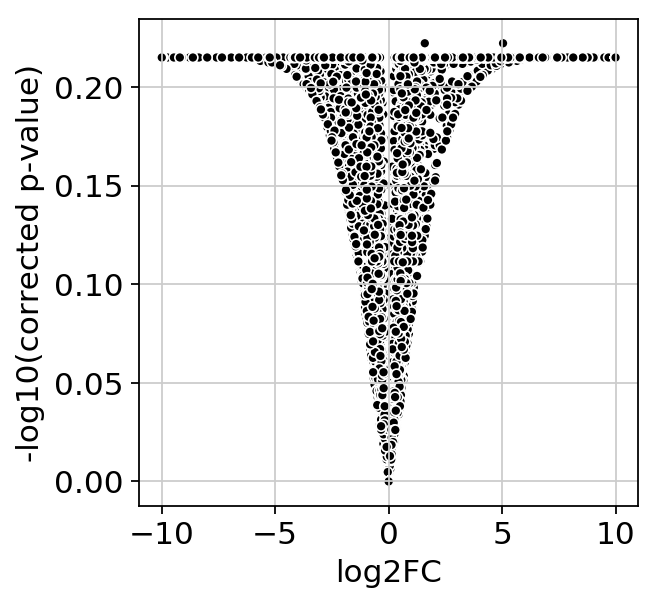

                gene      pval      qval  ...        mean  zero_mean  zero_variance
8207            Grk6  0.000055  0.599601  ...   86.733730      False          False
14421          Rnf14  0.000085  0.599601  ...   16.402367      False          False
16685          Tcof1  0.000130  0.608716  ...   40.763314      False          False
17953          Uqcrh  0.000189  0.609651  ...   75.088757      False          False
9435        Kcnq1ot1  0.000245  0.609651  ...   29.449705      False          False
4850            Ctsz  0.000439  0.609651  ...   55.497042      False          False
5694           Dusp7  0.000527  0.609651  ...   10.994083      False          False
7161            Gdi2  0.000696  0.609651  ...  147.023668      False          False
603    2610018G03Rik  0.000794  0.609651  ...   24.650887      False          False
14167           Rce1  0.000909  0.609651  ...   33.071006      False          False
5671           Dus2l  0.001103  0.609651  ...   12.863905      False        

In [0]:
subset_by = 'ref_annotation'
subset = 'T cell'
test_by = 'subtissue'
test_groups = ['MAT', 'BAT', 'GAT', 'SCAT']
pairwiseDE(test_by, test_groups, subset_by, subset)

Differential expression of fat cells between male and female mice.

Differential expression: M vs F


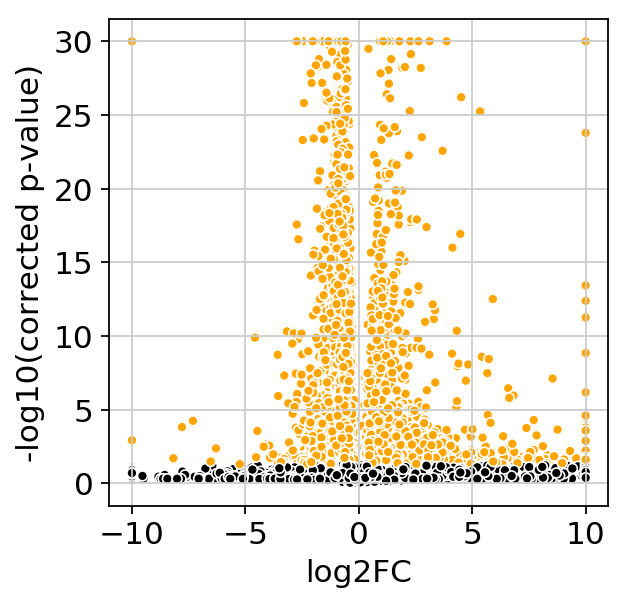

                gene           pval  ...  zero_mean  zero_variance
9823           Lars2  4.950116e-160  ...      False          False
5271           Ddx3y  9.531264e-133  ...      False          False
14612          Rps25  2.612823e-122  ...      False          False
15973           Sod1  1.577340e-119  ...      False          False
17783            Ubb  4.598838e-109  ...      False          False
14569           Rpl6  2.536035e-102  ...      False          False
7606          Gm1821   1.691683e-96  ...      False          False
13763         Ptp4a2   6.423246e-95  ...      False          False
3586            Cbx3   1.416281e-89  ...      False          False
17569           Tsix   7.474958e-85  ...      False          False
14603          Rps18   1.493220e-84  ...      False          False
14620          Rps3a   4.393690e-84  ...      False          False
1806           Actr2   5.777134e-84  ...      False          False
14624           Rps6   4.016093e-83  ...      False          F

In [0]:
test_by = 'mouse_sex'
test_groups = ['M', 'F']
pairwiseDE(test_by, test_groups)

# Dimensionality Reduction, Data Correction, Clustering and Cell Annotation

Identify the highly-variable genes in our dataset, genes with expression that is very different between cells. These our the target genes to look at as they are different between cells and can be used to identify different cell types.

The function also adds new columns to adata.var which indicates for each gene whether it is highly variable and what its mean expression, dispersion and normalized dispersion are.

In [0]:
sc.pp.highly_variable_genes(adata, max_mean=10, min_disp=0.5)

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Create two scatter plots showing dispersion of genes (normalized and non normalized) versus mean expression of genes where the highly variable genes are separately labeled. 

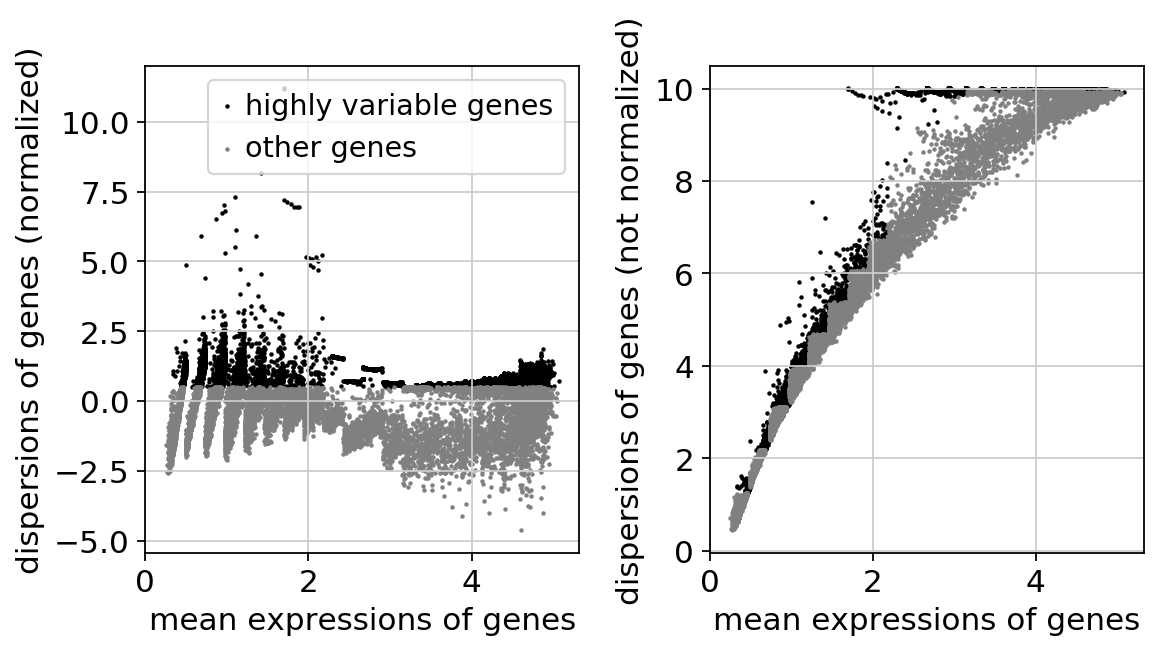

In [0]:
sc.pl.highly_variable_genes(adata)

## Dimensionality Reduction

Principal Component Analysis (PCA) reduces the dimensionality of the data by creating new variables (Principal components) that are linear combinations of the orginal variables which contain most of the variance in our dataset.

In [0]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:04)


Scatter plot showing our first two principal components.

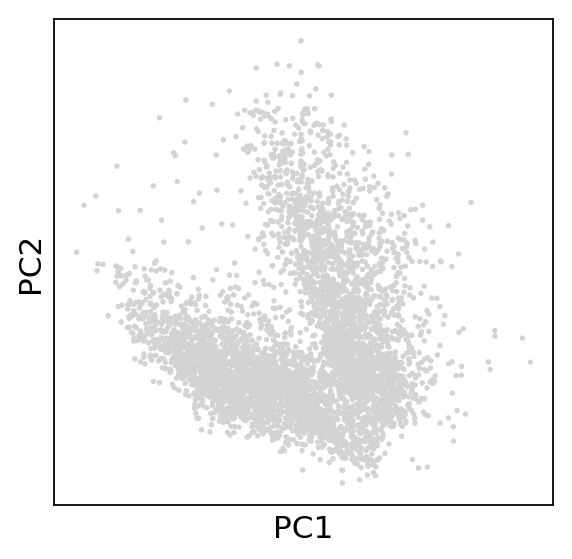

In [0]:
sc.pl.pca(adata)

Here the Principal Components are ranked according to the variance they represent in the data set. Each further principal component has a decreased explanation of the varaince it accounts for and this ranking gives information about how many PCs that should be considered in order to compute the neighborhood relations of cells in methods such as louvain clustering or tSNE visualization.

The number of PCs used is usually chosen when you have obtained enough PCs to explain the majority of the variance in your data and each additional PC does not contribute much.

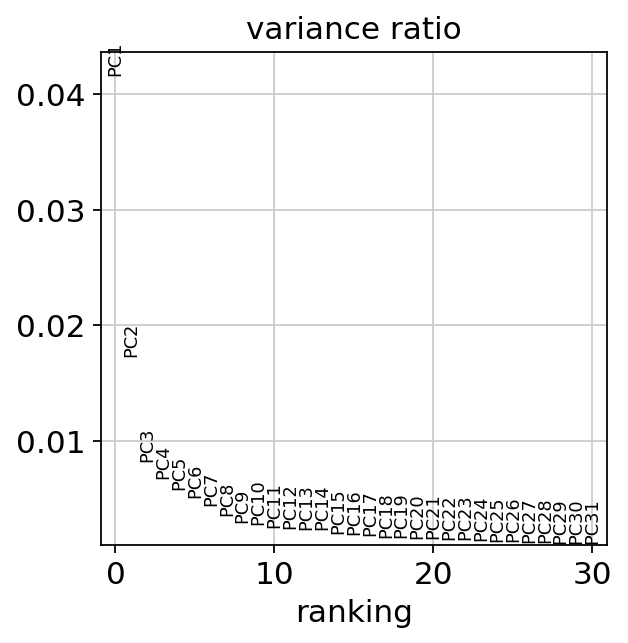

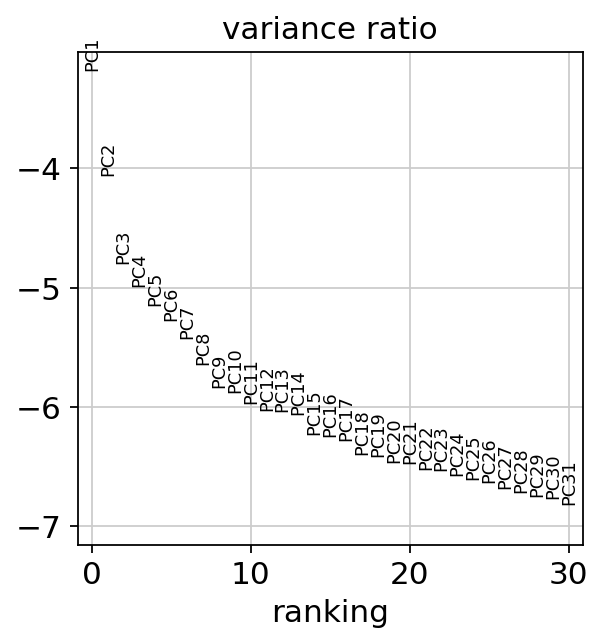

In [0]:
sc.pl.pca_variance_ratio(adata)
sc.pl.pca_variance_ratio(adata, log=True)

In [0]:
print('Total ratio of variance explained by the first 50 PCs: %.4f' %sum(adata.uns['pca']['variance_ratio'].tolist()[0:49]))

Total ratio of variance explained by the first 50 PCs: 0.1499


Compute the neighborhood graph of cells using the PCA representation.

In [0]:
sc.pp.neighbors(adata, n_neighbors=10)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)


Embed UMAP and t-SNE dimensionality reduction to the data.

In [0]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


In [0]:
sc.tl.tsne(adata)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:47)


## Data Correction

Check for batch effects of mouse_id, mouse_sex and plate by t-SNE projection.

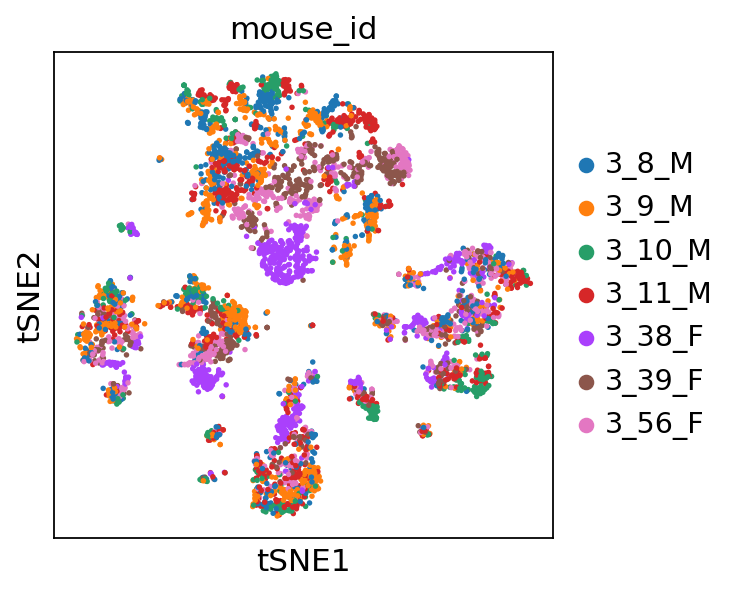

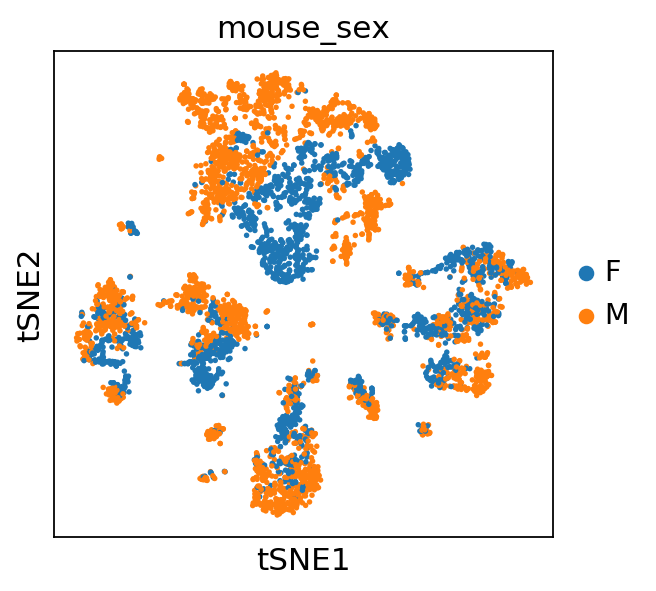

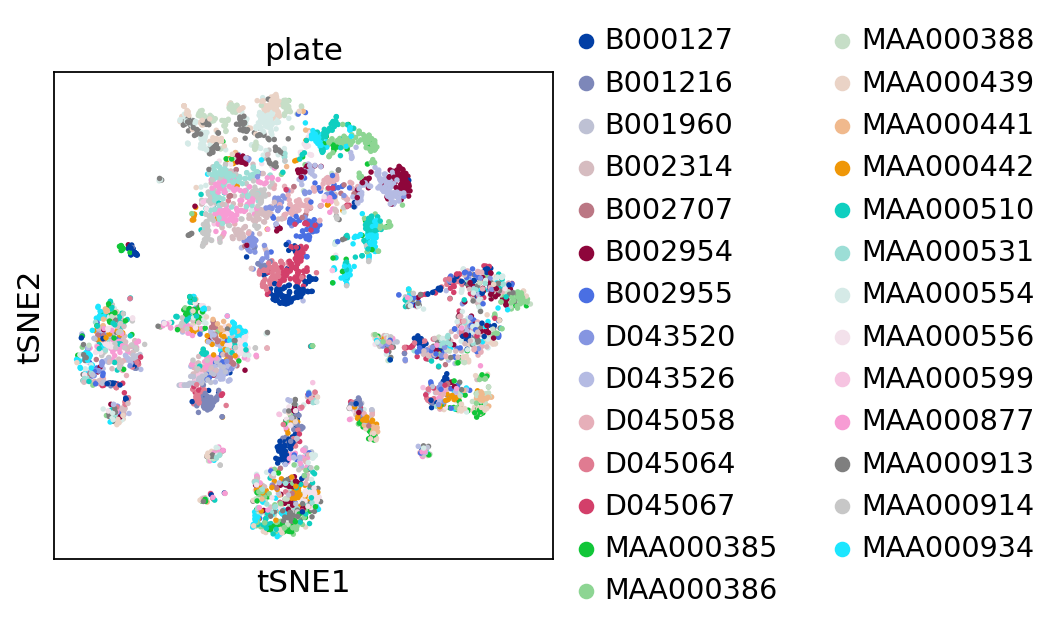

In [0]:
sc.pl.tsne(adata,color='mouse_id')
sc.pl.tsne(adata,color='mouse_sex')
sc.pl.tsne(adata,color='plate')

Batch correction using bbknn.

In [0]:
bk.bbknn(adata, batch_key='mouse_id')
bk.bbknn(adata, batch_key='mouse_sex')
bk.bbknn(adata, batch_key='plate')

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:02)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:00)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:03)


Visualization of post batch correction cells by t-SNE projection.

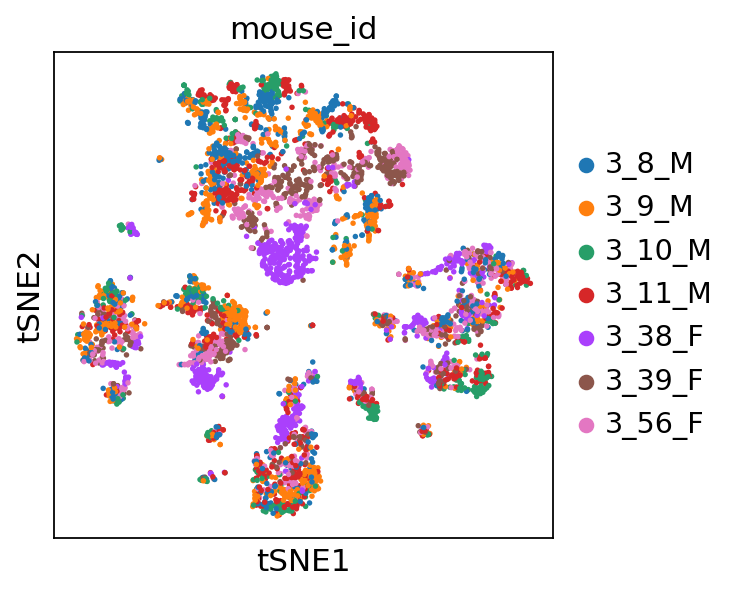

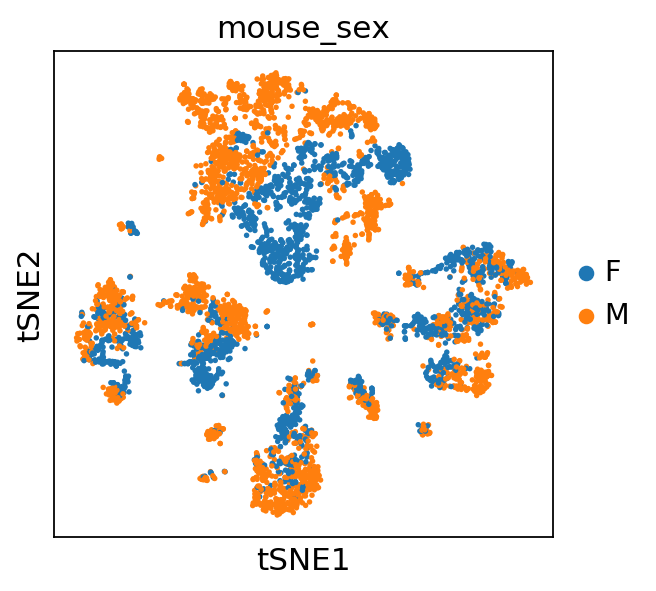

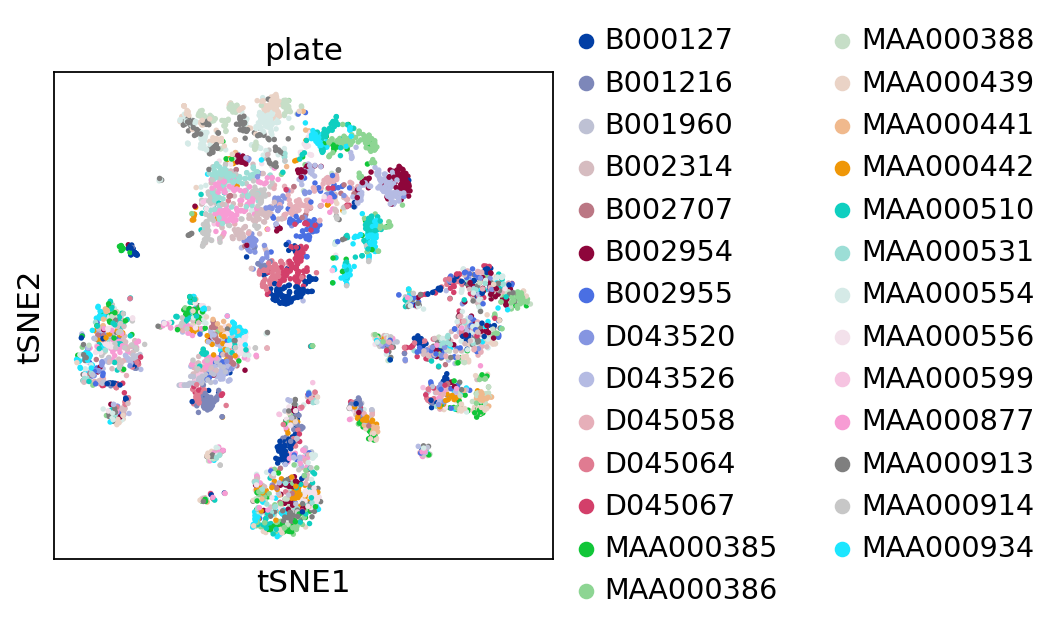

In [0]:
sc.pl.tsne(adata,color='mouse_id')
sc.pl.tsne(adata,color='mouse_sex')
sc.pl.tsne(adata,color='plate')

## Cell Clustering

Clustering using Louvain algorithm.

In [0]:
sc.tl.louvain(adata,resolution=0.9)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:02)


UMAP projection of cells with Louvain cluster labels and reference annotation labels.

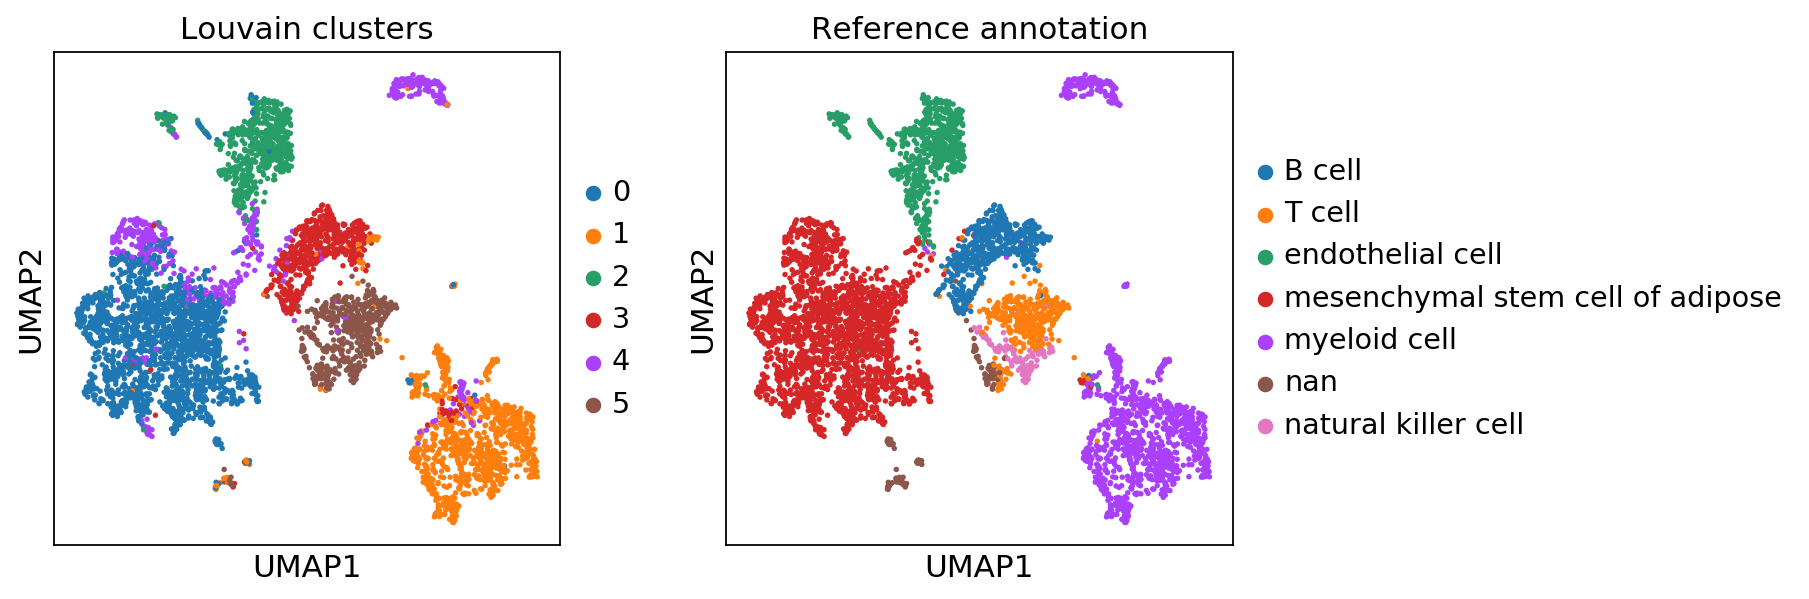

In [0]:
sc.pl.umap(adata, color=['louvain','ref_annotation'], title=['Louvain clusters', 'Reference annotation'])

T-SNE projection of cells with Louvain cluster labels and reference annotation labels.

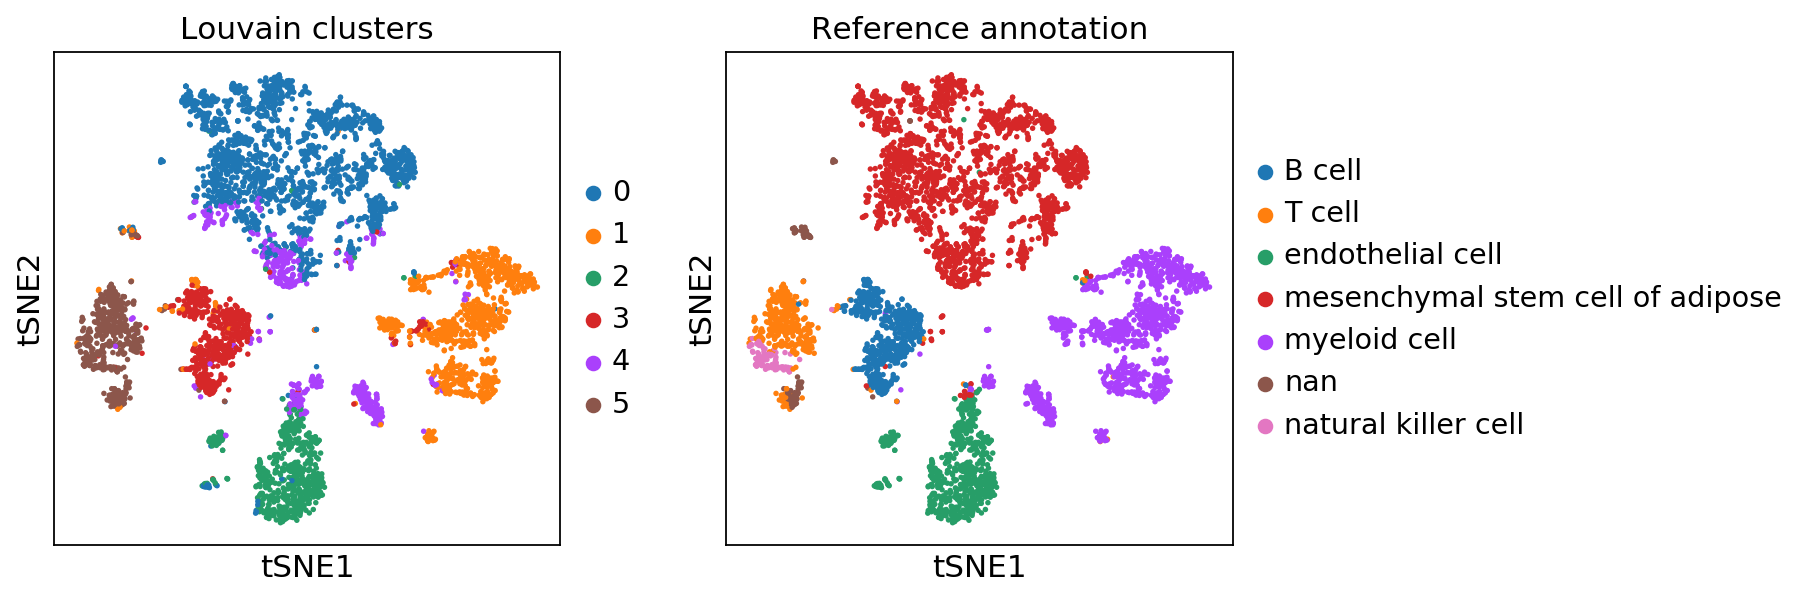

In [0]:
sc.pl.tsne(adata, color=['louvain','ref_annotation'], title=['Louvain clusters', 'Reference annotation'])

In [0]:
adata.write(results_file)

## Cell Annotation

### Annotation of Cell Clusters by Marker Genes

Compute a ranking for the highly expressed genes in each cluster using t-test and Wilcoxon rank-sum.

ranking genes


/usr/local/lib/python3.6/dist-packages/scanpy/tools/_rank_genes_groups.py:223: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


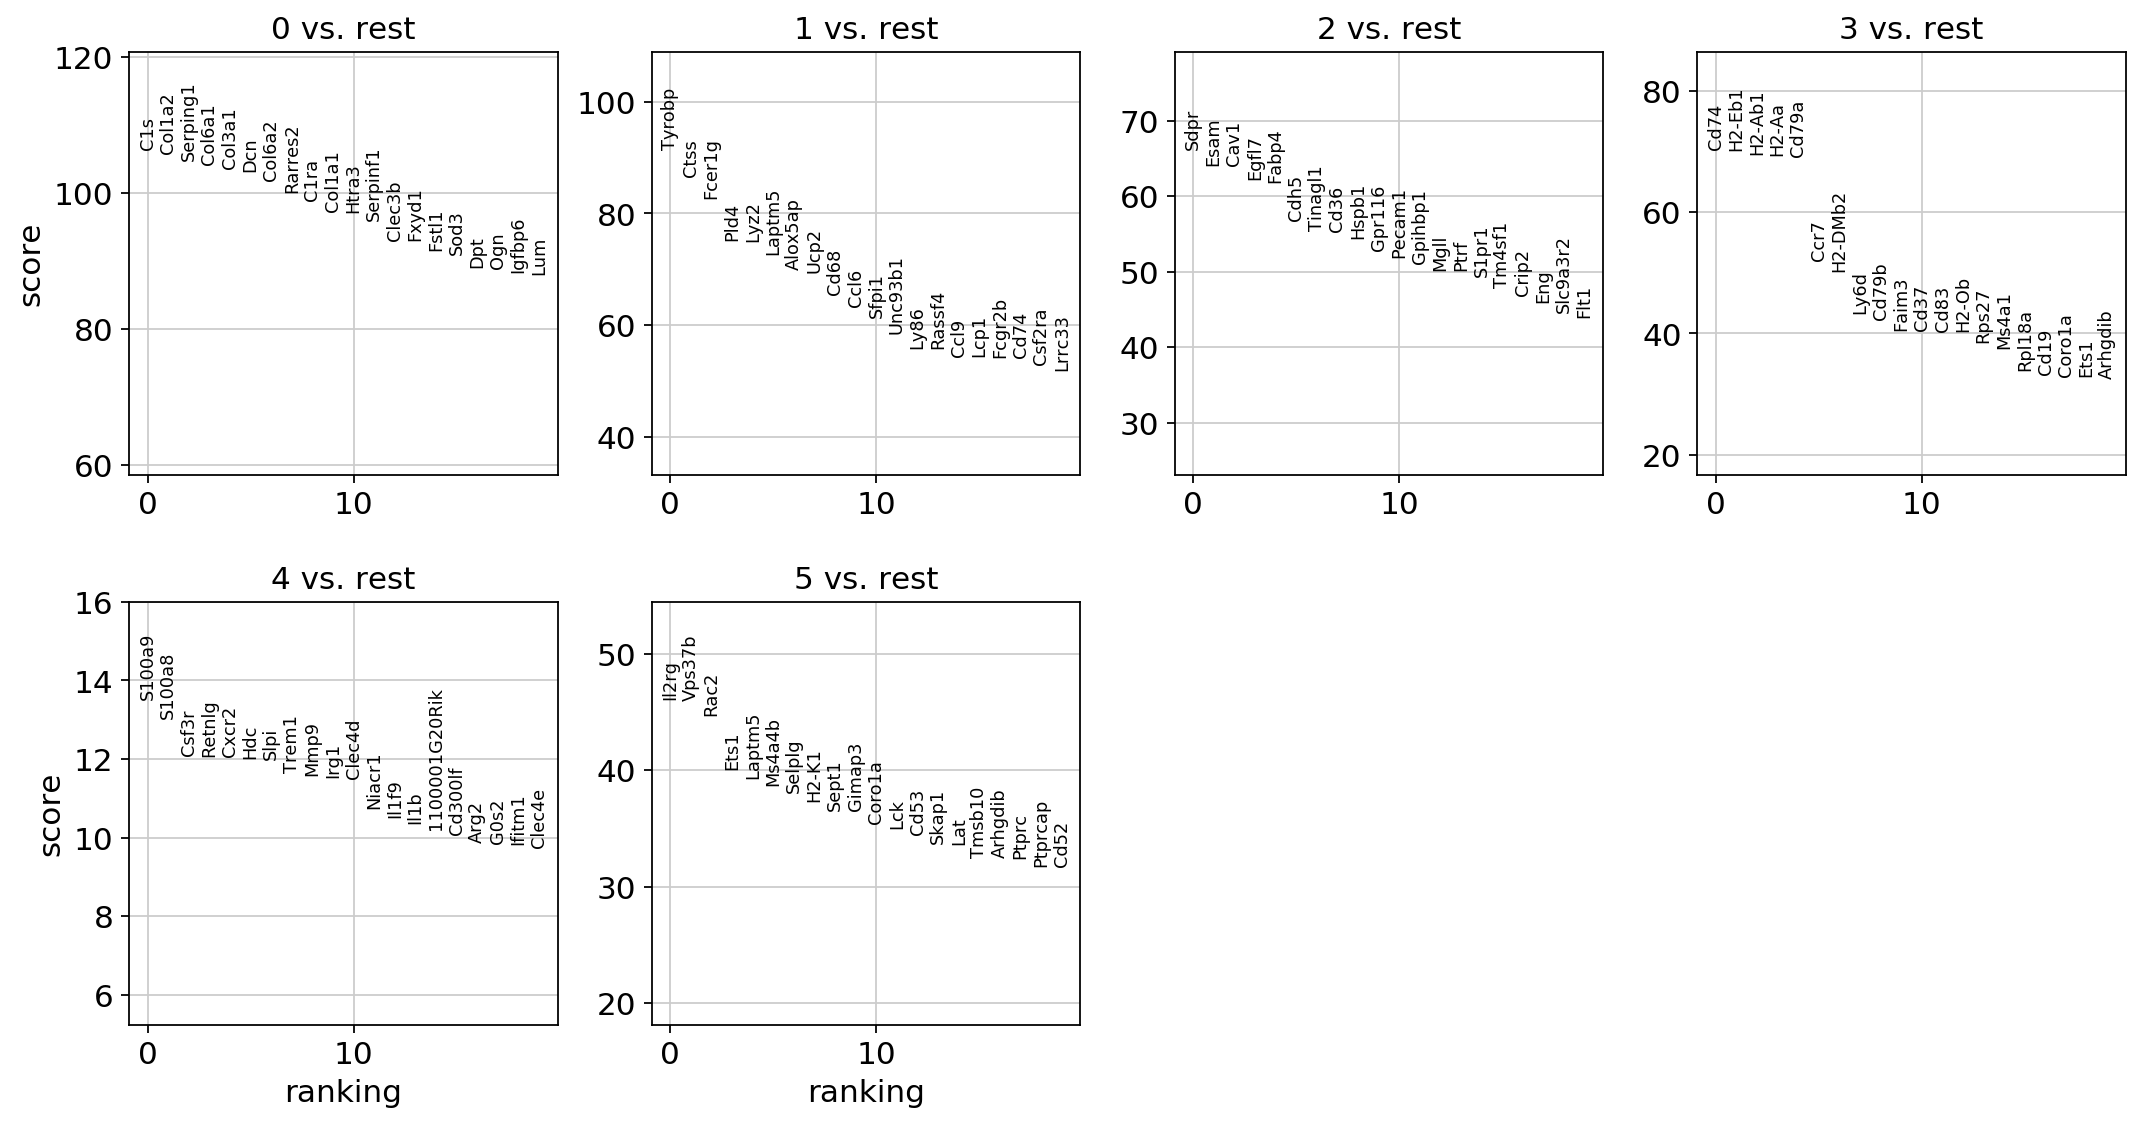

In [0]:
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test', use_raw=False)
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

ranking genes


/usr/local/lib/python3.6/dist-packages/scanpy/tools/_rank_genes_groups.py:388: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:14)


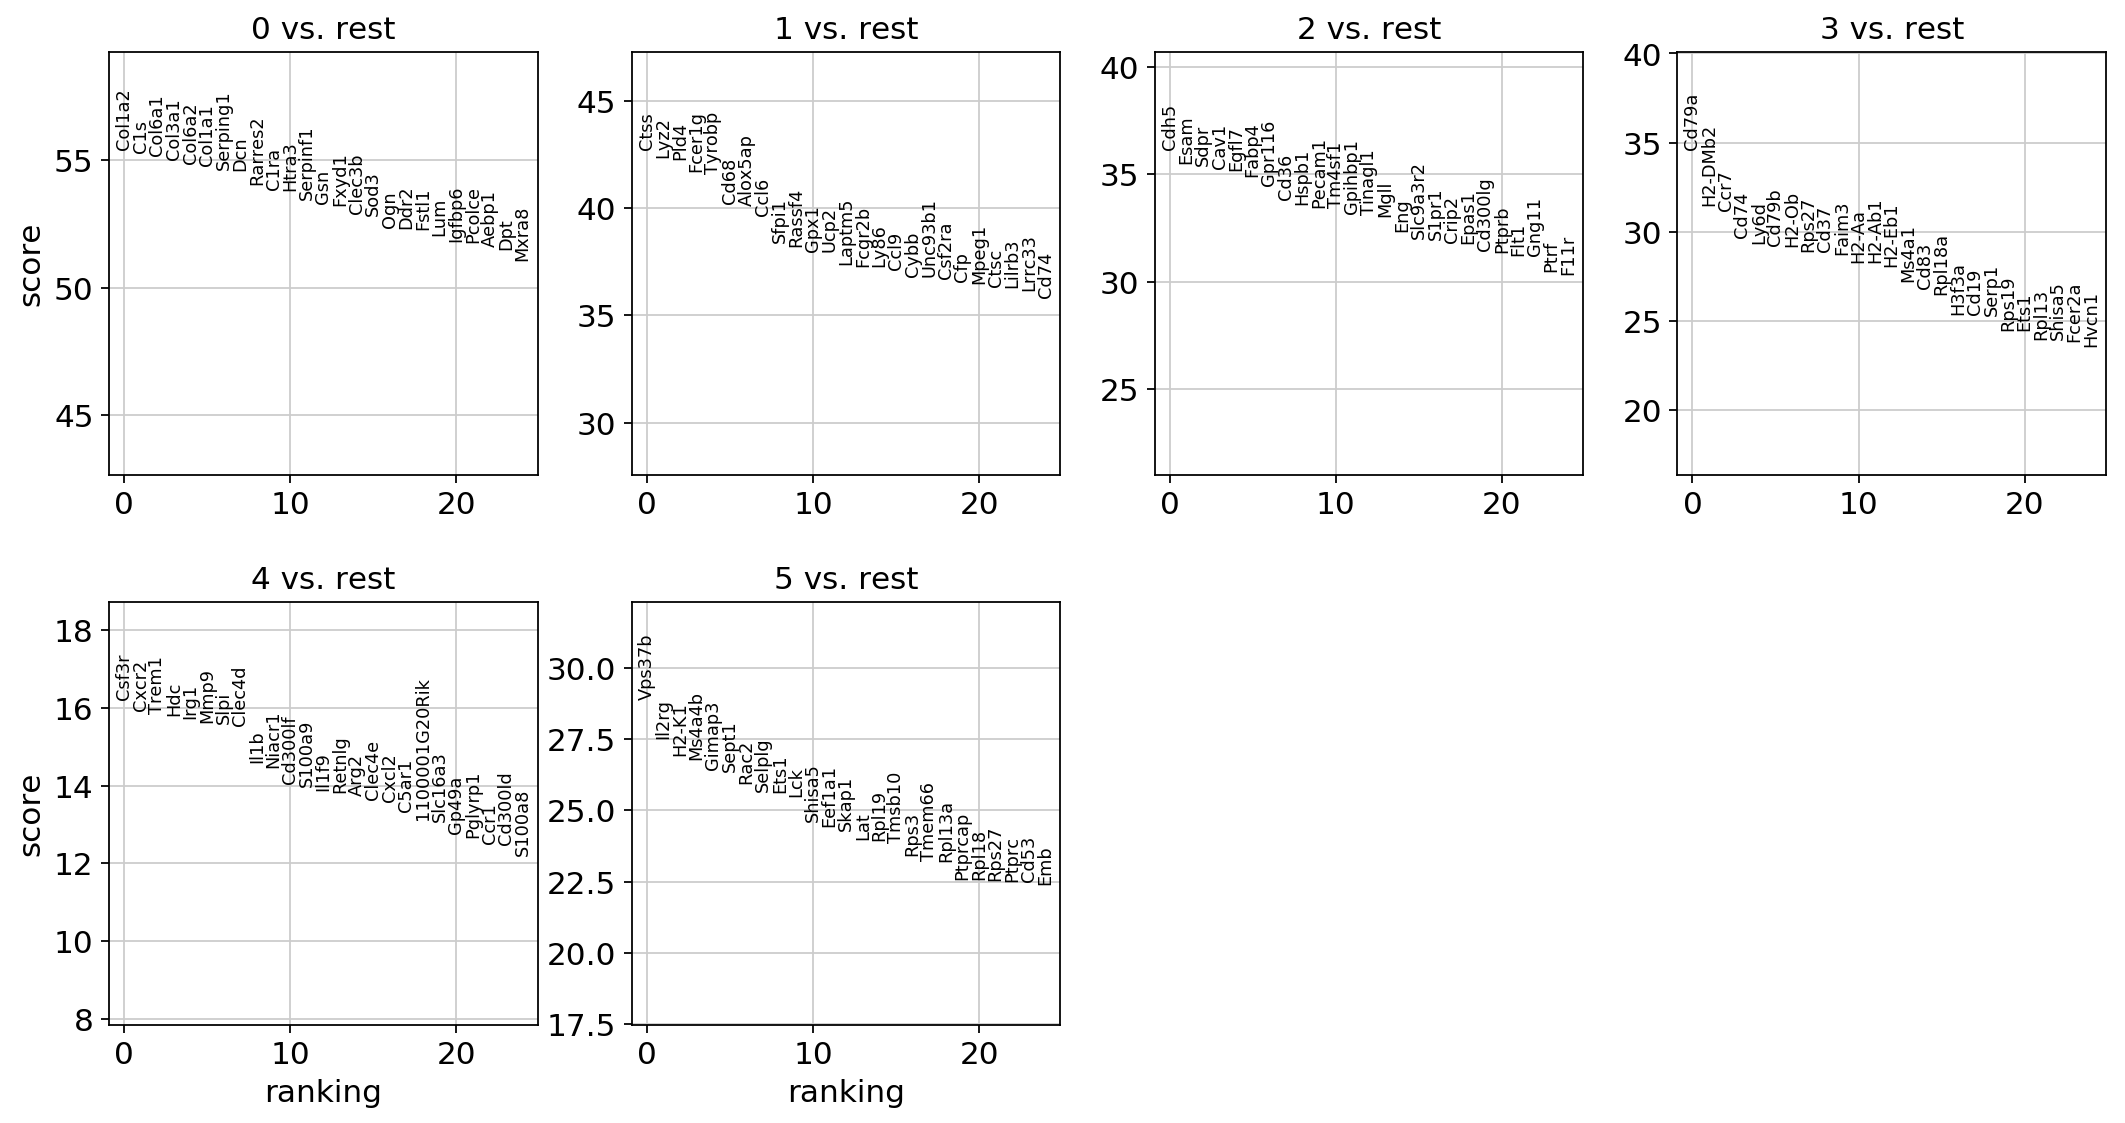

In [0]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon', use_raw=False)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

The top five expressed genes unique to each cluster.

In [0]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0       1      2        3      4       5
0  Col1a2    Ctss   Cdh5    Cd79a  Csf3r  Vps37b
1     C1s    Lyz2   Esam  H2-DMb2  Cxcr2   Il2rg
2  Col6a1    Pld4   Sdpr     Ccr7  Trem1   H2-K1
3  Col3a1  Fcer1g   Cav1     Cd74    Hdc  Ms4a4b
4  Col6a2  Tyrobp  Egfl7     Ly6d   Irg1  Gimap3

In [0]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n  0_p     1_n  1_p  ...    4_n           4_p     5_n            5_p
0  Col1a2  0.0    Ctss  0.0  ...  Csf3r  3.337319e-59  Vps37b  1.312455e-183
1     C1s  0.0    Lyz2  0.0  ...  Cxcr2  3.546437e-57   Il2rg  7.067288e-167
2  Col6a1  0.0    Pld4  0.0  ...  Trem1  1.372708e-56   H2-K1  9.592245e-160
3  Col3a1  0.0  Fcer1g  0.0  ...    Hdc  3.195908e-56  Ms4a4b  4.097572e-158
4  Col6a2  0.0  Tyrobp  0.0  ...   Irg1  1.085080e-55  Gimap3  7.136585e-154

[5 rows x 12 columns]

Collect all the marker genes from our outsourced list of known marker genes for the tissues in our dataset. The marker genes were retrieved from CellMarker database (http://biocc.hrbmu.edu.cn/CellMarker/).

In [0]:
data = open('/content/drive/My Drive/IntegratedProject/Data/Mouse_cell_markers.txt', 'r')
data = csv.reader(data, delimiter='\t')

header = next(data)
marker_genes_dict=dict()
tissue = 'Adipose tissue'       #Have to update this line to take marker genes for all the tissues in our dataset.

for row in data:
    if row[1] == tissue and not row[6] == 'NA':
      if not row[5] in marker_genes_dict.keys():
        marker_genes_dict[row[5]] = []
      genelist=row[8].split(', ')
      marker_genes_dict[row[5]] += genelist

Compare the marker genes collected above with the genes that are the highest expressed in each cell type for each cluster.

In [0]:
marker_overlap = sc.tl.marker_gene_overlap(adata, marker_genes_dict, key='rank_genes_groups')
marker_overlap

0    1    2    3    4    5
Adipose-derived stem cell  1.0  2.0  2.0  0.0  0.0  2.0
White fat cell             0.0  0.0  0.0  0.0  0.0  0.0
Mesenchymal stem cell      1.0  2.0  1.0  0.0  0.0  2.0
Brown fat cell             0.0  0.0  0.0  0.0  0.0  0.0
Beige fat cell             0.0  0.0  0.0  0.0  0.0  0.0
Endothelial cell           0.0  0.0  1.0  0.0  0.0  0.0
Stem cell                  1.0  1.0  1.0  0.0  0.0  0.0
Fat cell (adipocyte)       0.0  0.0  1.0  0.0  0.0  0.0
M1 macrophage              0.0  0.0  0.0  0.0  1.0  0.0
M2 macrophage              0.0  0.0  0.0  0.0  0.0  0.0
Macrophage                 0.0  1.0  0.0  0.0  1.0  0.0
Preadipocyte               0.0  0.0  0.0  0.0  0.0  0.0
Osteogenic cell            2.0  0.0  0.0  0.0  0.0  0.0
Chondrogenic cell          0.0  0.0  0.0  0.0  0.0  0.0
Myogenic cell              0.0  0.0  0.0  0.0  0.0  0.0
Immune cell                0.0  0.0  0.0  0.0  1.0  0.0
Mesenchymal stromal cell   0.0  1.0  0.0  0.0  0.0  1.0

Create the same table seen above but normalizes the overlap to show which cell type each cluster would be annotated as using this supervised method.

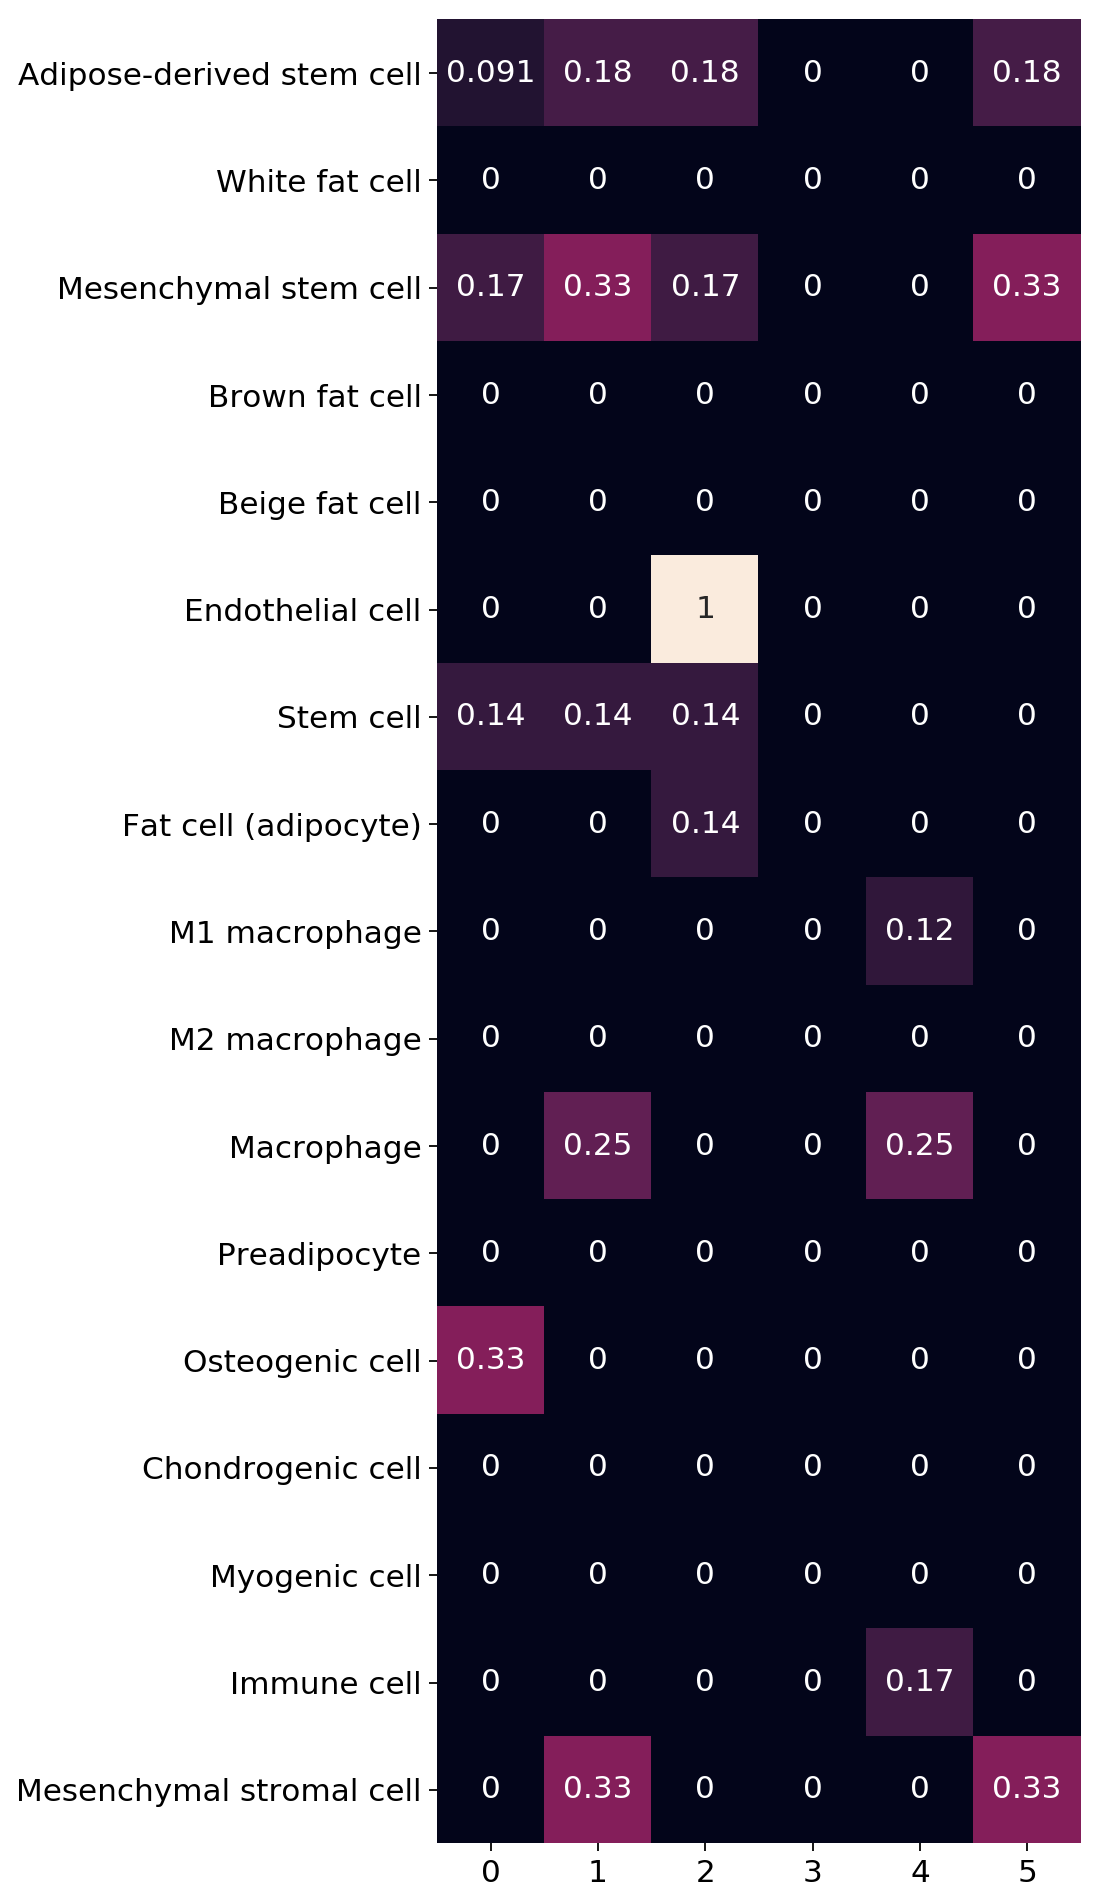

In [0]:
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
marker_overlap_norm = sc.tl.marker_gene_overlap(adata, marker_genes_dict, key='rank_genes_groups', normalize='reference')
sb.heatmap(marker_overlap_norm, cbar=False, annot=True, square=True, ax=ax)

Create a list of each cell type that will be the cluster names based on the max value in the overlap shown in the previous two figures.

In [0]:
new_cluster_names = []
for col in marker_overlap_norm.columns:
  new_cluster_names.append(marker_overlap_norm[col].idxmax())
new_cluster_names

['Osteogenic cell',
 'Mesenchymal stem cell',
 'Endothelial cell',
 'Adipose-derived stem cell',
 'Macrophage',
 'Mesenchymal stem cell']

Create a new column in adata.obs to store the associated annotation using marker genes.

In [0]:
adata.obs = adata.obs.assign(annotation_by_markers='')
for i in range(len(new_cluster_names)):
  adata.obs.loc[adata.obs['louvain'] == str(i), 'annotation_by_markers'] = new_cluster_names[i]
adata.obs

plate mouse_id  ... louvain      annotation_by_markers
A1.B000127.3_38_F.1.1      B000127   3_38_F  ...       4                 Macrophage
A1.B002314.3_56_F.1.1      B002314   3_56_F  ...       0            Osteogenic cell
A1.D045058.3_39_F.1.1      D045058   3_39_F  ...       0            Osteogenic cell
A1.D045067.3_38_F.1.1      D045067   3_38_F  ...       0            Osteogenic cell
A1.MAA000388.3_11_M.1.1  MAA000388   3_11_M  ...       0            Osteogenic cell
...                            ...      ...  ...     ...                        ...
P9.MAA000556.3_9_M.1.1   MAA000556    3_9_M  ...       5      Mesenchymal stem cell
P9.MAA000877.3_11_M.1.1  MAA000877   3_11_M  ...       3  Adipose-derived stem cell
P9.MAA000913.3_9_M.1.1   MAA000913    3_9_M  ...       5      Mesenchymal stem cell
P9.MAA000914.3_9_M.1.1   MAA000914    3_9_M  ...       3  Adipose-derived stem cell
P9.MAA000934.3_9_M.1.1   MAA000934    3_9_M  ...       5      Mesenchymal stem cell

[4929 rows x 11 columns]

Visualize three different UMAPs/tSNEs the first showing the cells colored by their  assigned cluster from the louvain clustering, the second based on the cell type from the datasets annotation and the third by the new annotation by markers label.

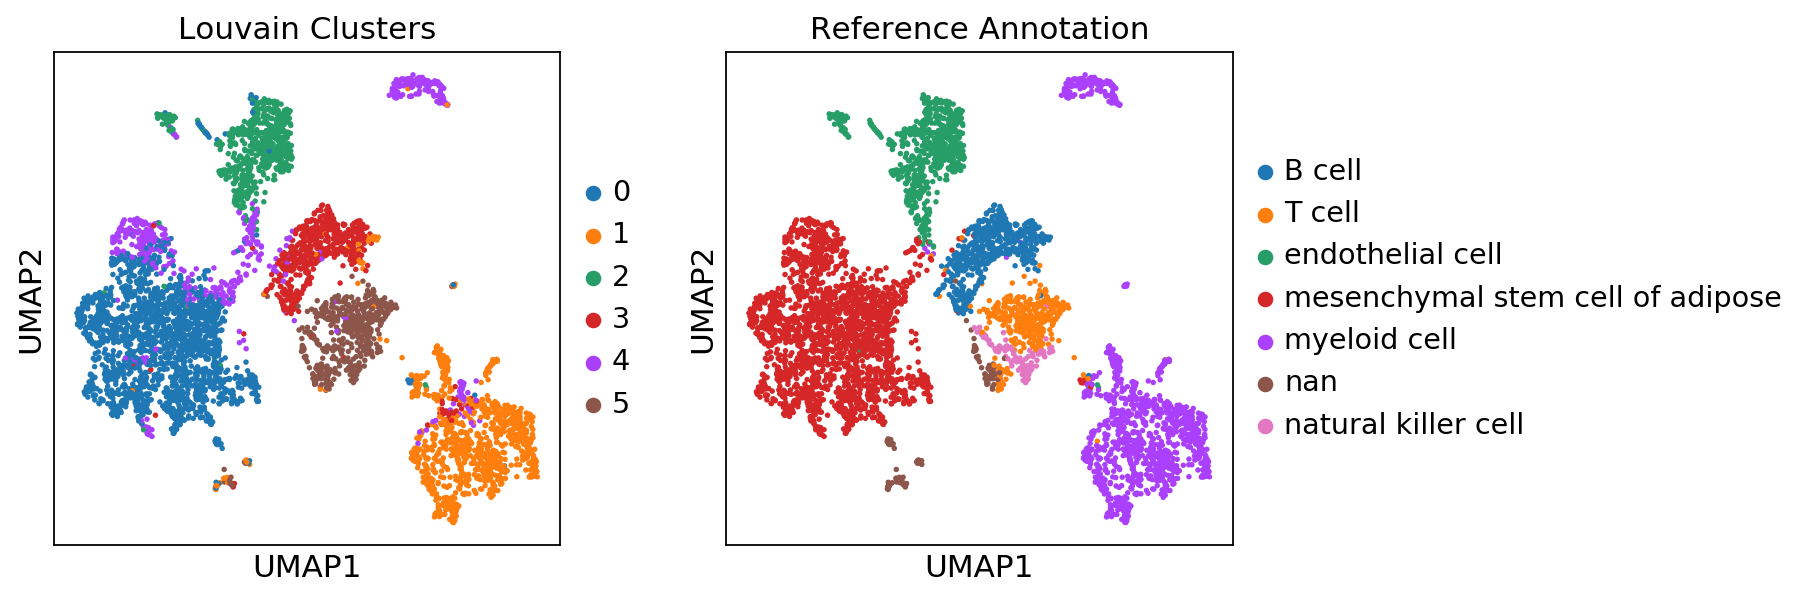

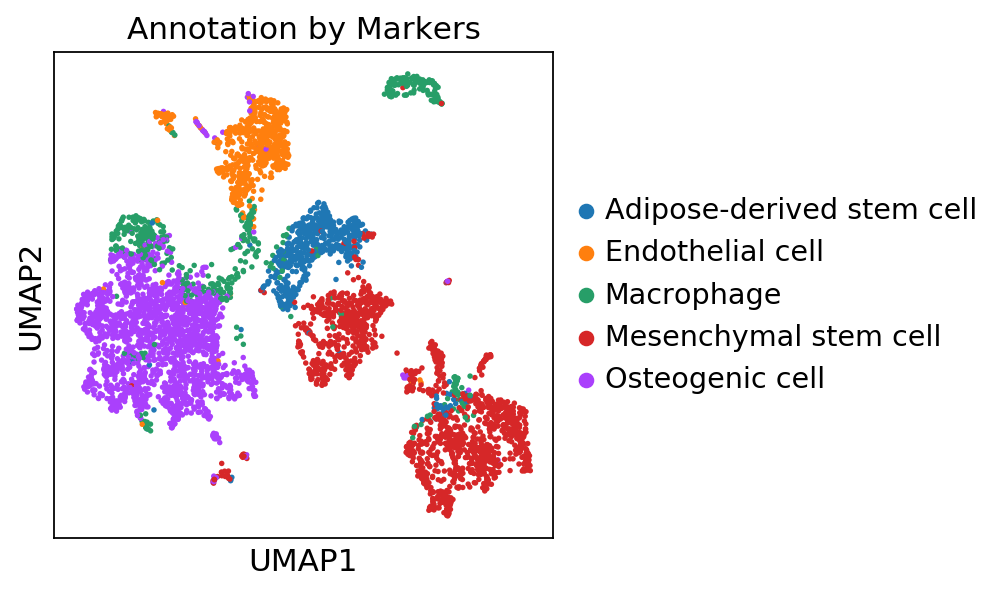

In [0]:
sc.pl.umap(adata, color=['louvain','ref_annotation'], title=['Louvain Clusters','Reference Annotation'])
sc.pl.umap(adata, color='annotation_by_markers', title='Annotation by Markers')

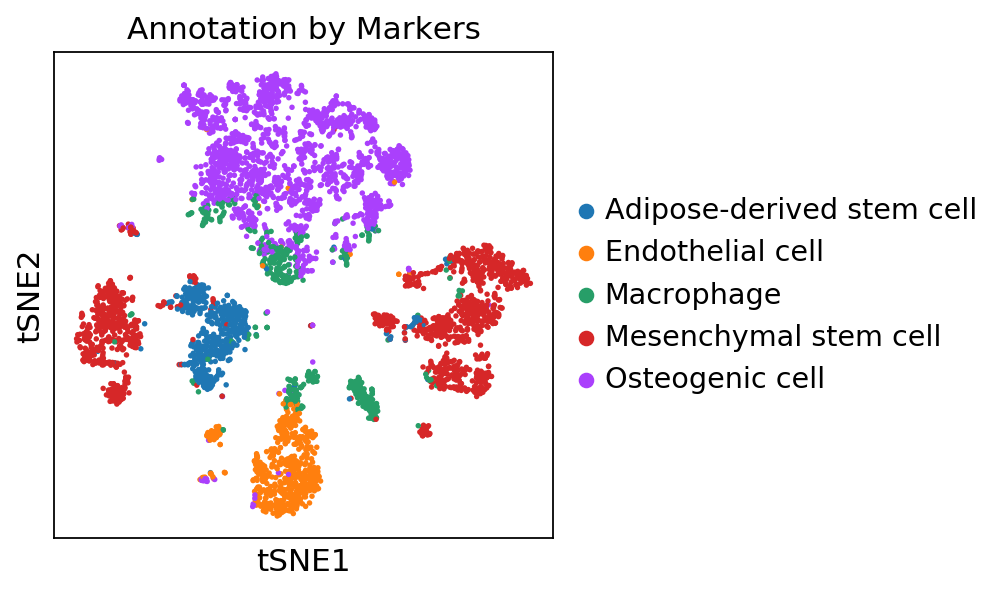

In [0]:
sc.pl.tsne(adata, color=['louvain','ref_annotation'], title=['Louvain Clusters','Reference Annotation'])
sc.pl.tsne(adata, color='annotation_by_markers', title='Annotation by Markers')

In [0]:
adata_copy = adata.copy()

Rank the genes by reference cell types to recover the marker genes of those cell types.

In [0]:
sc.tl.rank_genes_groups(adata_copy, 'ref_annotation', method='wilcoxon', use_raw=False)

ranking genes


/usr/local/lib/python3.6/dist-packages/scanpy/tools/_rank_genes_groups.py:388: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:13)


Display the top five ranked genes for each cell type.

In [0]:
marker_df = pd.DataFrame(adata_copy.uns['rank_genes_groups']['names']).head(5)
marker_df

B cell T cell endothelial cell  ... myeloid cell      nan natural killer cell
0    Cd79a   Cd3e             Sdpr  ...       Tyrobp    Gata3                Nkg7
1     Ccr7   Cd3d             Cav1  ...       Fcer1g     Cd82                Ccl5
2  H2-DMb2   Cd3g            Fabp4  ...         Lyz2   Spint2            AW112010
3     Ly6d    Lat           Tm4sf1  ...         Ccl6   Rnf128               Il2rb
4    Cd79b   Tcf7             Cdh5  ...      Alox5ap  Tspan13              Klrb1c

[5 rows x 7 columns]

Make new dictionary of marker genes corresponding to the cell types in the reference annotation.

In [0]:
marker_genes_dict = {}
for col in marker_df.columns:
  if not col == 'nan':
    marker_genes_dict[col] = marker_df[col].tolist()
marker_genes_dict

{'B cell': ['Cd79a', 'Ccr7', 'H2-DMb2', 'Ly6d', 'Cd79b'],
 'T cell': ['Cd3e', 'Cd3d', 'Cd3g', 'Lat', 'Tcf7'],
 'endothelial cell': ['Sdpr', 'Cav1', 'Fabp4', 'Tm4sf1', 'Cdh5'],
 'mesenchymal stem cell of adipose': ['Dcn',
  'Col1a2',
  'Col3a1',
  'Htra3',
  'Col1a1'],
 'myeloid cell': ['Tyrobp', 'Fcer1g', 'Lyz2', 'Ccl6', 'Alox5ap'],
 'natural killer cell': ['Nkg7', 'Ccl5', 'AW112010', 'Il2rb', 'Klrb1c']}

Repeat steps done previously to annotate the Louvain clusters with the new set of marker genes.

In [0]:
marker_overlap = sc.tl.marker_gene_overlap(adata, marker_genes_dict, key='rank_genes_groups')
marker_overlap

0    1    2    3    4    5
B cell                            0.0  0.0  0.0  5.0  0.0  0.0
T cell                            0.0  0.0  0.0  0.0  0.0  5.0
endothelial cell                  0.0  0.0  5.0  0.0  0.0  0.0
mesenchymal stem cell of adipose  5.0  0.0  0.0  0.0  0.0  0.0
myeloid cell                      0.0  5.0  0.0  0.0  3.0  0.0
natural killer cell               0.0  0.0  0.0  0.0  0.0  2.0

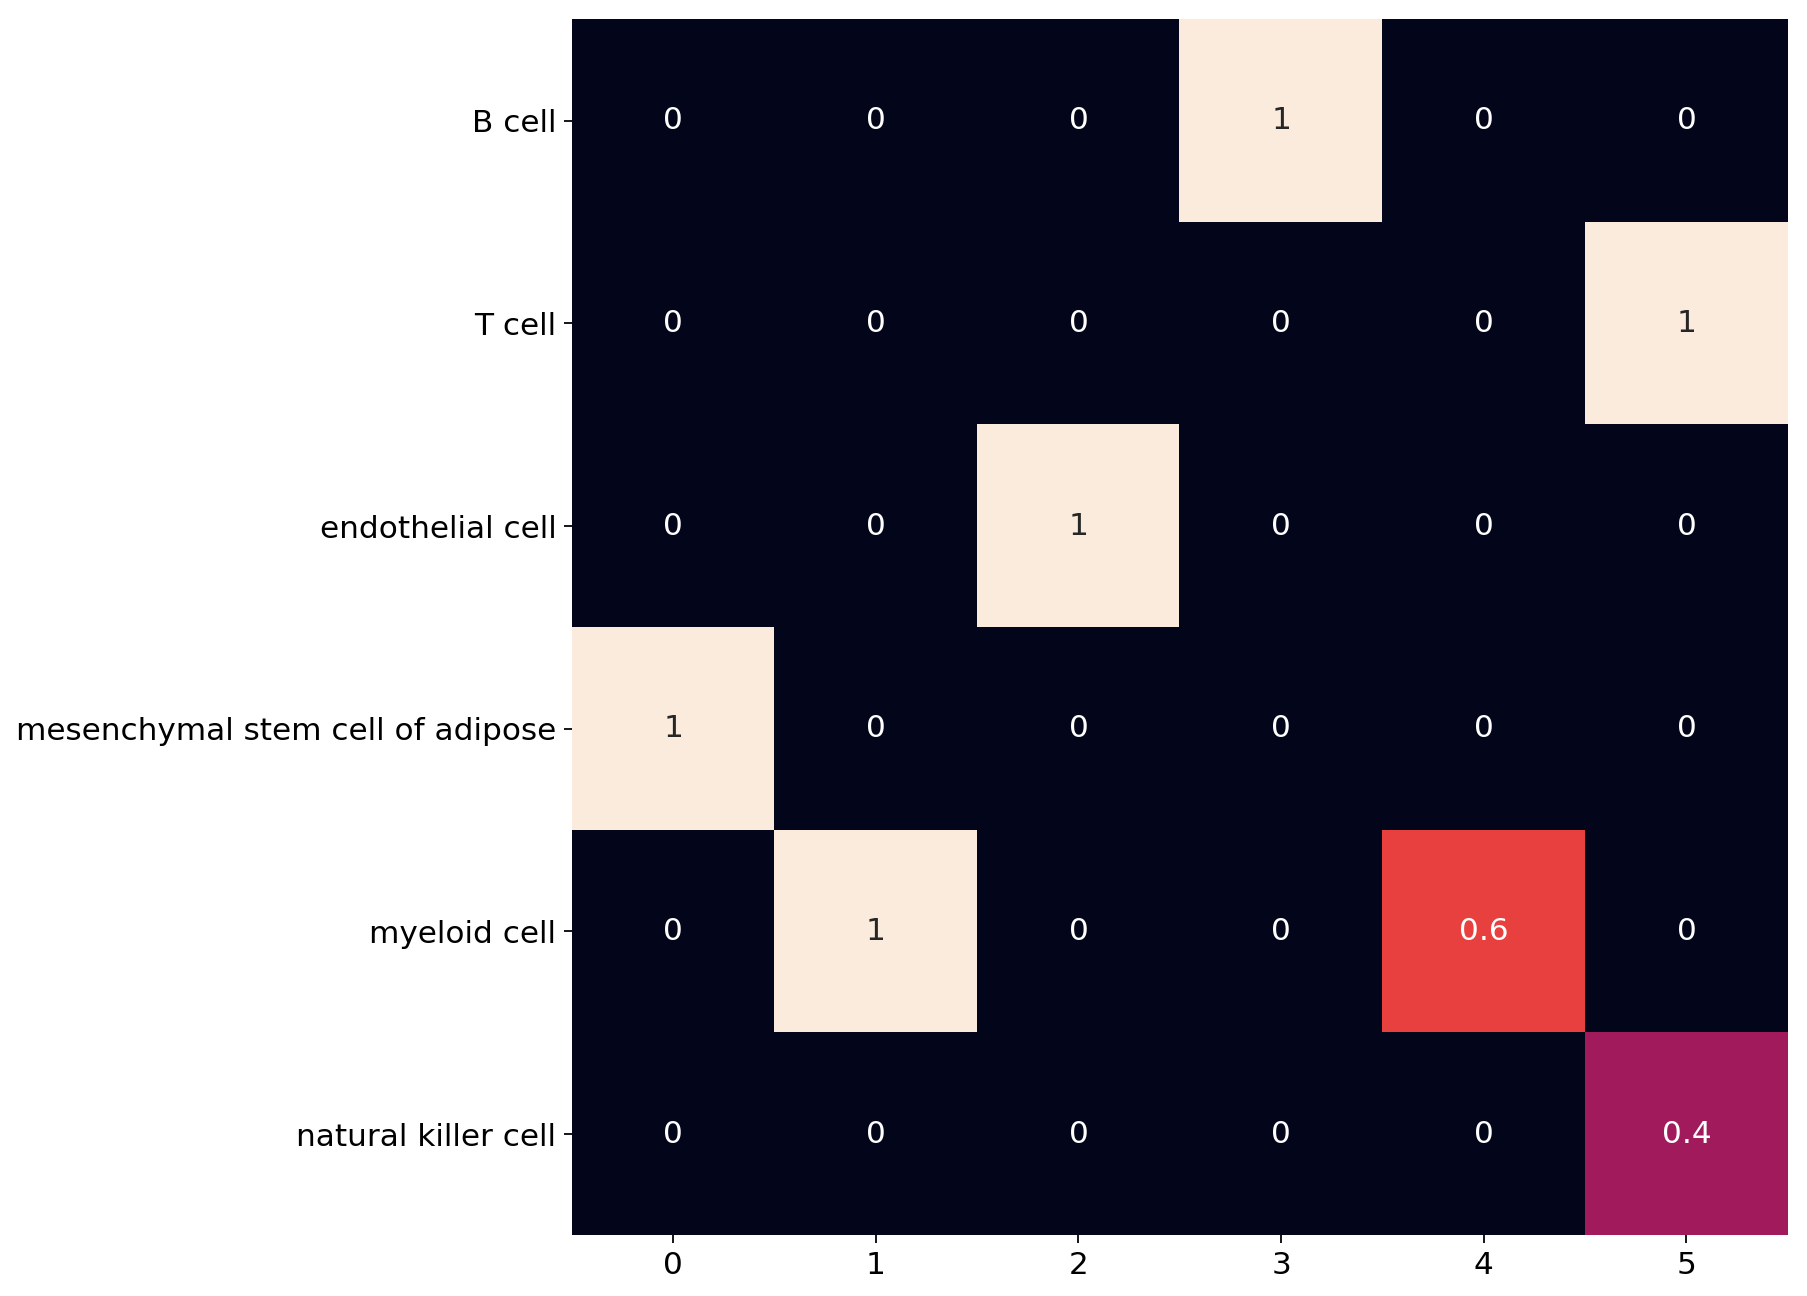

In [0]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
marker_overlap_norm = sc.tl.marker_gene_overlap(adata, marker_genes_dict, key='rank_genes_groups', normalize='reference')
sb.heatmap(marker_overlap_norm, cbar=False, annot=True, square=True, ax=ax)

In [0]:
new_cluster_names = []
for col in marker_overlap_norm.columns:
  new_cluster_names.append(marker_overlap_norm[col].idxmax())
new_cluster_names

In [0]:
adata.obs = adata.obs.assign(annotation_by_markers='')
for i in range(len(new_cluster_names)):
  adata.obs.loc[adata.obs['louvain'] == str(i), 'annotation_by_markers'] = new_cluster_names[i]
adata.obs

... storing 'annotation_by_markers' as categorical


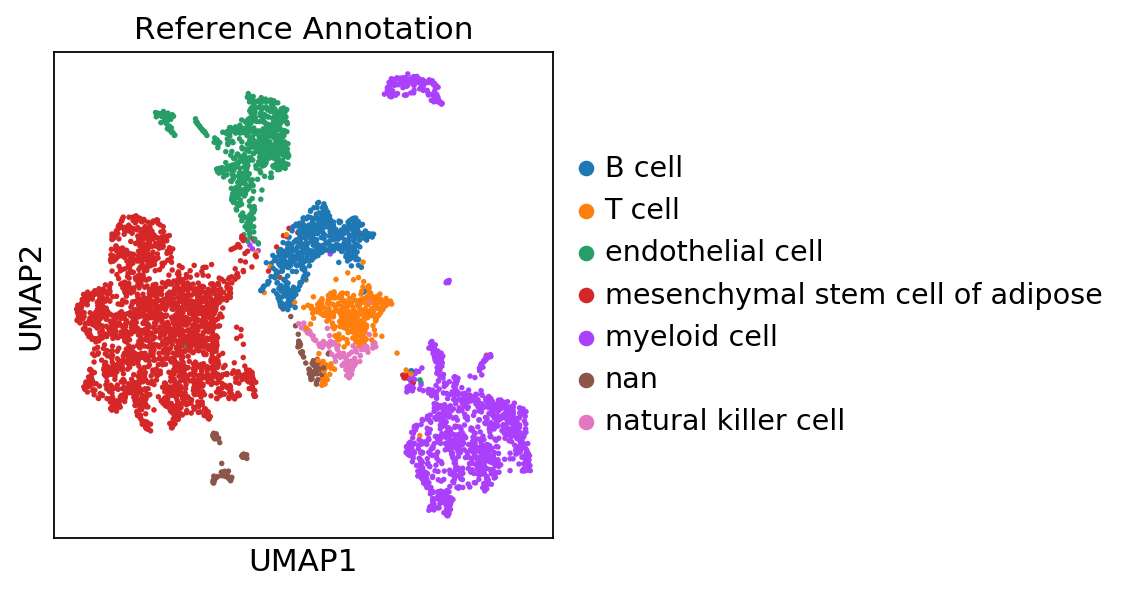

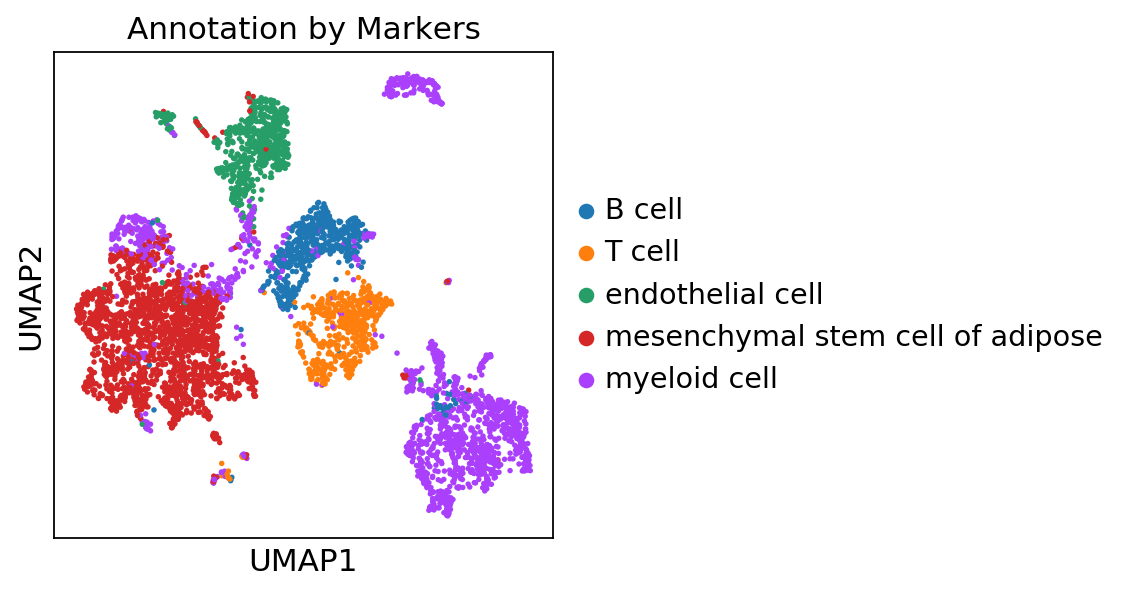

In [0]:
sc.pl.umap(adata, color='ref_annotation', title='Reference Annotation')
sc.pl.umap(adata, color='annotation_by_markers', title='Annotation by Markers')

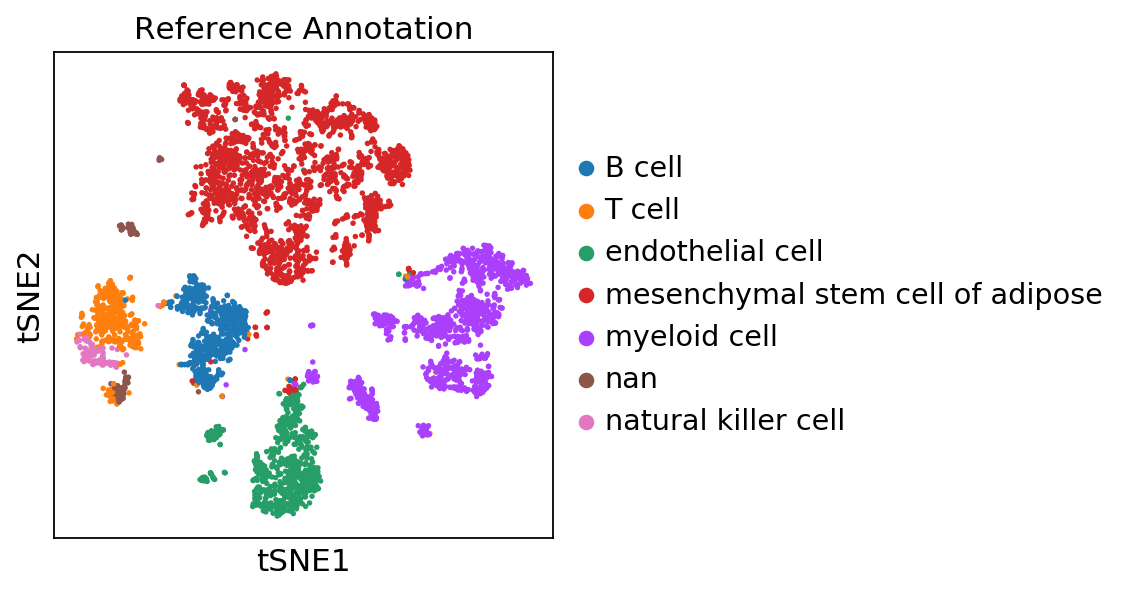

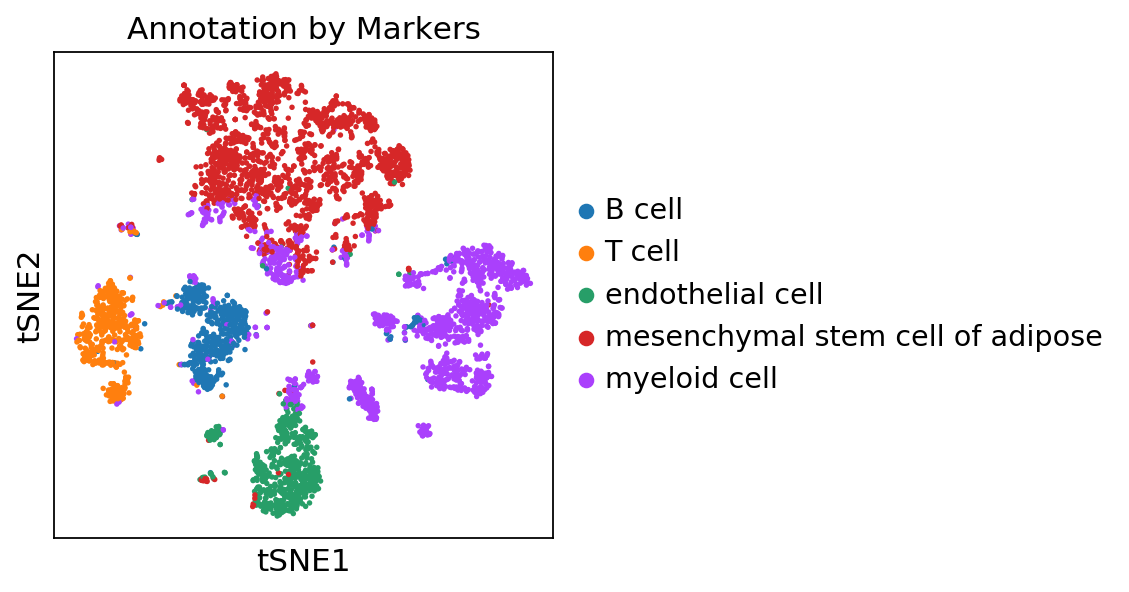

In [0]:
sc.pl.tsne(adata, color='ref_annotation', title='Reference Annotation')
sc.pl.tsne(adata, color='annotation_by_markers', title='Annotation by Markers')

### Cell Classification by Machine Learning

In [0]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

Create list of annotations which are all the annotations taken from the original data set.

In [0]:
data = adata[adata.obs['ref_annotation']!='nan']
data_na = adata[adata.obs['ref_annotation']=='nan']
annotations = data.obs['ref_annotation'].tolist()

Get the cross-validation scores for 5-fold cross-validation using the default settings of 3 classification methods - Support Vector Machine using a linear kernel, k-nearest neighbors (k=5 by default), random forest (the number of trees of 10 by default).



In [0]:
clf_svm = LinearSVC()
scores_svm = cross_val_score(clf_svm, data.X, annotations, scoring='accuracy', cv=5)

clf_knn = KNeighborsClassifier()
scores_knn = cross_val_score(clf_knn, data.X, annotations, scoring='accuracy', cv=5)

clf_rf = RandomForestClassifier()
scores_rf = cross_val_score(clf_rf, data.X, annotations, scoring='accuracy', cv=5)

print ("5-fold CV scores for SVM: mean %.2f, sd %.2f " %(scores_svm.mean(),scores_svm.std()))
print ("5-fold CV scores for kNN: mean %.2f, sd %.2f " %(scores_knn.mean(),scores_knn.std()))
print ("5-fold CV scores for random forest: mean %.2f, sd %.2f " %(scores_rf.mean(),scores_rf.std()))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

5-fold CV scores for SVM: mean 0.96, sd 0.01 
5-fold CV scores for kNN: mean 0.80, sd 0.03 
5-fold CV scores for random forest: mean 0.98, sd 0.00 


PCA displaying number of components and explained variance for the first 50 components.

Text(0.5, 0, 'Number of components')

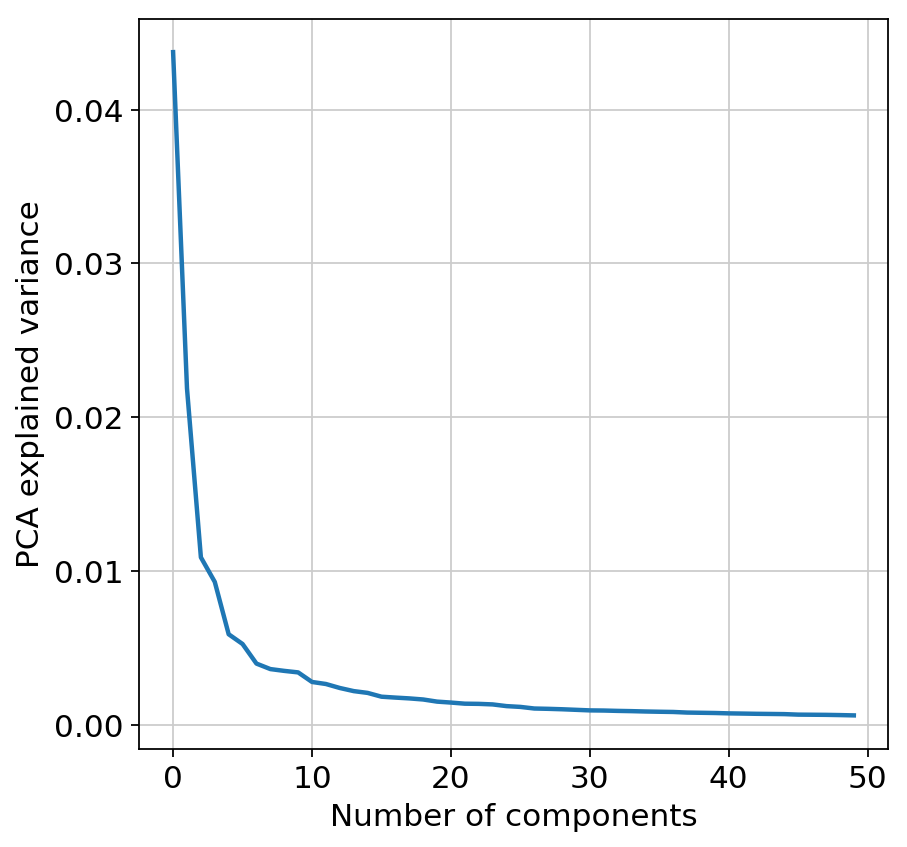

In [0]:
pca = PCA(n_components=50)
pca.fit(data.X)
pca
fig, (ax0) = plt.subplots(nrows=1, sharex=True, figsize=(6, 6))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')
ax0.set_xlabel('Number of components')

Search for the best combination of PCA truncation (the number of principal components) and classifier regularization (C for SVM and the number of estimators for random forest).

In [0]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
clf_svm = LinearSVC()
clf_knn = KNeighborsClassifier()
clf_rf = RandomForestClassifier()

pca = PCA()
pipe_svm = Pipeline(steps=[('pca', pca), ('svm', clf_svm)])
pipe_knn = Pipeline(steps=[('pca', pca), ('knn', clf_knn)])
pipe_rf = Pipeline(steps=[('pca', pca), ('rf', clf_rf)])

grid_n_components = list(range(10, 30, 1))
grid_n_neighbors = list(range(5, 25, 2))
grid_C = [float(x) for x in np.arange(0.0, 1.0, 0.1)]
grid_n_estimators = list(range(10, 150, 10))

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid_svm = {
    'pca__n_components': grid_n_components,
    'svm__C': [0.1,1,10],
}

param_grid_knn = {
    'pca__n_components': grid_n_components,
    'knn__n_neighbors': grid_n_neighbors,
}

param_grid_rf = {
    'pca__n_components': grid_n_components,
    'rf__n_estimators': grid_n_estimators,
}

search_svm = GridSearchCV(pipe_svm, param_grid_svm, iid=False, cv=3)
search_knn = GridSearchCV(pipe_knn, param_grid_knn, iid=False, cv=3)
search_rf = GridSearchCV(pipe_rf, param_grid_rf, iid=False, cv=3)
search_svm.fit(data.X, annotations)
search_knn.fit(data.X, annotations)
search_rf.fit(data.X, annotations)

In [0]:
print("Best parameter for SVM (CV score=%0.3f):" % search_svm.best_score_)
print(search_svm.best_params_)
print("Best parameter for kNN (CV score=%0.3f):" % search_knn.best_score_)
print(search_knn.best_params_)
print("Best parameter for random forest (CV score=%0.3f):" % search_rf.best_score_)
print(search_rf.best_params_)

Best parameter for SVM (CV score=0.992):
{'pca__n_components': 22, 'svm__C': 1}
Best parameter for kNN (CV score=0.993):
{'knn__n_neighbors': 5, 'pca__n_components': 29}
Best parameter for random forest (CV score=0.995):
{'pca__n_components': 20, 'rf__n_estimators': 50}


Fit the models using the best parameter found for each classification method on the labeled cells and use them to predict the cell type of unlabeled cells. The predictions for each method are then compared.

In [0]:
pca_svm = PCA(n_components=22)
pca_svm.fit(data.X)
data_t_svm = pca_svm.transform(data.X)
data_t_na_svm = pca_svm.transform(data_na.X)
clf_svm = LinearSVC(C=1)

pca_knn = PCA(n_components=29)
pca_knn.fit(data.X)
data_t_knn = pca_knn.transform(data.X)
data_t_na_knn = pca_knn.transform(data_na.X)
clf_knn = KNeighborsClassifier(n_neighbors=5)

pca_rf = PCA(n_components=20)
pca_rf.fit(data.X)
data_t_rf = pca_rf.transform(data.X)
data_t_na_rf = pca_rf.transform(data_na.X)
clf_rf = RandomForestClassifier(n_estimators=50)

In [0]:
clf_svm.fit(data_t_svm, annotations)
predicted_na_svm = clf_svm.predict(data_t_na_svm)

clf_knn.fit(data_t_knn, annotations)
predicted_na_knn = clf_knn.predict(data_t_na_knn)

clf_rf.fit(data_t_rf, annotations)
predicted_na_rf = clf_rf.predict(data_t_na_rf)

cells_na = list(data_na.obs_names)
for i in range(len(cells_na)):
  print('%s\t%s\t%s\t%s' %(cells_na[i],predicted_na_svm[i],predicted_na_knn[i],predicted_na_rf[i]))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


A13.D045064.3_38_F.1.1	T cell	B cell	mesenchymal stem cell of adipose
A15.B000127.3_38_F.1.1	endothelial cell	mesenchymal stem cell of adipose	mesenchymal stem cell of adipose
A17.B000127.3_38_F.1.1	endothelial cell	mesenchymal stem cell of adipose	mesenchymal stem cell of adipose
A20.B000127.3_38_F.1.1	endothelial cell	mesenchymal stem cell of adipose	mesenchymal stem cell of adipose
B12.MAA000510.3_8_M.1.1	endothelial cell	mesenchymal stem cell of adipose	mesenchymal stem cell of adipose
B12.MAA000531.3_8_M.1.1	T cell	T cell	T cell
B14.MAA000439.3_10_M.1.1	T cell	T cell	T cell
B16.MAA000531.3_8_M.1.1	T cell	T cell	T cell
B5.MAA000388.3_11_M.1.1	endothelial cell	mesenchymal stem cell of adipose	mesenchymal stem cell of adipose
B6.MAA000385.3_10_M.1.1	endothelial cell	mesenchymal stem cell of adipose	myeloid cell
C12.D045064.3_38_F.1.1	T cell	T cell	T cell
C14.B001216.3_38_F.1.1	T cell	T cell	T cell
C14.D045064.3_38_F.1.1	T cell	T cell	T cell
C20.B000127.3_38_F.1.1	endothelial cell	mes

# Conversion to a Loom file

In [0]:
def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.as_matrix()]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    arr = np.array(arr_ip, dtype=dtyp)
    return arr

ClusterMarkers_0 = pd.DataFrame(
    index=adata.raw.var.index,
    columns=[str(x) for x in range(max(set([int(x) for x in adata.obs['louvain']])) + 1)]
)

ClusterMarkers_0_avg_logFC = pd.DataFrame(
    index=adata.raw.var.index,
    columns=[str(x) for x in range(max(set([int(x) for x in adata.obs['louvain']])) + 1)]
)

ClusterMarkers_0_pval = pd.DataFrame(
    index=adata.raw.var.index,
    columns=[str(x) for x in range(max(set([int(x) for x in adata.obs['louvain']])) + 1)]
)

ClusterMarkers_0.fillna(0, inplace=True)
ClusterMarkers_0_avg_logFC.fillna(0, inplace=True)
ClusterMarkers_0_pval.fillna(0, inplace=True)

for i in range(max(set([int(x) for x in adata.obs['louvain']])) + 1):
    i = str(i)
    tot_genes = len(adata.uns['rank_genes_groups']['pvals_adj'][i])
    sigGenes = adata.uns['rank_genes_groups']['pvals_adj'][i] < 0.05
    deGenes = np.logical_and(np.logical_or(adata.uns['rank_genes_groups']['logfoldchanges'][i] >= 1.5,
                                           adata.uns['rank_genes_groups']['logfoldchanges'][i] <= -1.5),
                             np.isfinite(adata.uns['rank_genes_groups']['logfoldchanges'][i]))
    sigAndDE = np.logical_and(sigGenes, deGenes)
    names = adata.uns['rank_genes_groups']['names'][i][sigAndDE]
    ClusterMarkers_0.loc[names, i] = 1
    ClusterMarkers_0_avg_logFC.loc[names, i] = np.around(adata.uns['rank_genes_groups']['logfoldchanges'][i][sigAndDE],
                                                         decimals=6)
    ClusterMarkers_0_pval.loc[names, i] = np.around(adata.uns['rank_genes_groups']['pvals_adj'][i][sigAndDE],
                                                    decimals=6)

metaJson = {}
metaJson["metrics"] = []
metaJson["annotations"] = []

main_dr = pd.DataFrame(adata.obsm['X_umap'], columns=['_X', '_Y'])

metaJson['embeddings'] = [
    {
        "id": -1,
        "name": "HVG UMAP"
    }
]

Embeddings_X = pd.DataFrame()
Embeddings_Y = pd.DataFrame()

embeddings_id = 1

if 'X_tsne' in adata.obsm.keys():
    Embeddings_X[str(embeddings_id)] = pd.DataFrame(adata.obsm['X_tsne'])[0]
    Embeddings_Y[str(embeddings_id)] = pd.DataFrame(adata.obsm['X_tsne'])[1]
    metaJson['embeddings'].append(
        {
            "id": embeddings_id,
            "name": "HVG t-SNE"
        }
    )
    embeddings_id += 1

Embeddings_X[str(embeddings_id)] = pd.DataFrame(adata.obsm['X_pca'])[0]
Embeddings_Y[str(embeddings_id)] = pd.DataFrame(adata.obsm['X_pca'])[1]
metaJson['embeddings'].append(
    {
        "id": embeddings_id,
        "name": "HVG PC1/PC2"
    }
)

metaJson["clusterings"] = [
    {
        "id": 0,
        "group": "Louvain",
        "name": "Louvain default resolution",
        "clusters": [],
        "clusterMarkerMetrics": [
            {
                "accessor": "avg_logFC",
                "name": "Avg. logFC",
                "description": "Average log fold change from Wilcox test"
            }, {
                "accessor": "pval",
                "name": "Adjusted P-Value",
                "description": "Adjusted P-Value from Wilcox test"
            }
        ]
    }
]

for i in range(max(set([int(x) for x in adata.obs['louvain']])) + 1):
    clustDict = {}
    clustDict['id'] = i
    clustDict['description'] = f'Unannotated Cluster {i}'
    metaJson['clusterings'][0]['clusters'].append(clustDict)

clusterings = pd.DataFrame()

clusterings["0"] = adata.obs['louvain'].values.astype(np.int64)

col_attrs = {
    "CellID": np.array(adata.obs.index),
    "Embedding": dfToNamedMatrix(main_dr),
    "Embeddings_X": dfToNamedMatrix(Embeddings_X),
    "Embeddings_Y": dfToNamedMatrix(Embeddings_Y),
    "Clusterings": dfToNamedMatrix(clusterings),
    "ClusterID": np.array(adata.obs['louvain'].values)
}

for col in adata.obs.keys():
    if type(adata.obs[col].dtype) == pd.core.dtypes.dtypes.CategoricalDtype:
        metaJson["annotations"].append(
            {
                "name": col,
                "values": list(set(adata.obs[col].values))
            }
        )
    else:
        metaJson["metrics"].append(
            {
                "name": col
            }
        )
    col_attrs[col] = np.array(adata.obs[col].values)

row_attrs = {
    "Gene": np.array(adata.raw.var.index),
    "ClusterMarkers_0": dfToNamedMatrix(ClusterMarkers_0),
    "ClusterMarkers_0_avg_logFC": dfToNamedMatrix(ClusterMarkers_0_avg_logFC),
    "ClusterMarkers_0_pval": dfToNamedMatrix(ClusterMarkers_0_pval)
}

attrs = {"MetaData": json.dumps(metaJson)}

attrs['MetaData'] = base64.b64encode(zlib.compress(json.dumps(metaJson).encode('ascii'))).decode('ascii')

lp.create(
    filename="/content/drive/My Drive/IntegratedProject/Data/write/LoomFiles/Fat.loom",
    layers=(adata.raw.X).T,
    row_attrs=row_attrs,
    col_attrs=col_attrs,
    file_attrs=attrs
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
